## <center> Proyecto Final Estadistica Avanzada Multivariada </center>
# <center>Predicción de Demanda y Oferta de Energía en Colombia</center> 

**Autores:**

Sarah Henao  
Julian Herrera

## Introducción

En este documento, se presentará la metodología de ciencia de datos definida para el proyecto de Estadistica Avanzada Multivariada, aplicada al problema de Predicción de Demanda y Oferta de Energía en el sistema interconectado nacional de energía colombiano. 

El objetivo del proyecto es predecir la generación de energía renovable y demanda de energía en colombia para encontrar un optimo en la generación de energía no renovable. Para esto, se define una metodología cientifica para llevar a cabo todos los pasos necesarios para obtener un modelo de machine learning capaz de predecir estas variables satisfactoriamente.

Como objetivo del curso, se busca desarrollar habilidades de transformación y selección de variables, exploración de datos y, en mayor medida, entrenamiento de modelos de machine learning para la predicción de series de tiempo.
 
 
Indice (Metodología)

- Base de datos
- Exploración de datos
- Extracción y transformación de variables
- Limpieza
- Modelación
  - Selección de variables
  - Entrenamiento
  - Selección del Modelo
  - Validación
- Competencia de Modelos
- Predicción de Energía no renovable
- Conclusiones

Estos son los pasos generales. **A medida que se avance en la exploración y desarrollo se agregarán los pasos realizados**.



### Base de datos

Los datos son extraidos del portal Sinergox de la empresa XM perteneciente al Grupo ISA. En este portal se alojan todos los datos recogidos por el sistema interconectado nacional de energía para su uso en el *Mercado de Energía Mayorista*.

En este portal se alojan datos de 6 categorías principales:

- Hidrología: Contiene toda la información relacionada con la generación de energía hidraulica.
- Demanta: Variables relacionadas con la demanda de energía
- Oferta y Generación: Se refiere a las variables relacionadas con la generación de energía, la cual se divide en 5 grupos
  - Hidraulica
  - Eolica
  - Solar
  - Termica
  - Cogeneradores
- Transacciones y precios: Esta información es extraida del mercado de transacciones de energía.
- Intercambios internacionales
- Calculo de emisiones CO2

En este trabajo, se centrará la atención en las variables de demanda y generación, concretamente en la demanda total (Demanda del SIN) y la generación total por tipo de energía. Debido a que no se cuenta con el conocimiento necesarios para seleccionar otras variables que puedan explicar las objetivo, no se van a extraer otras variables. 

Para extraer los datos del portal, es posible utilizar una API puesta a disposición por Sinergox, donde se cuenta con una librería de python para ayudar y facilitar la extracción de los datos. Además, el API cuenta con guías y ejemplos para esto. El API se encuentra en un repositorio de *GitHub*.

Es posible instalar por medio de pip la librería, aunque también es posible descargar el repositorio e importarlo como un .py en la carpeta del proyecto. La librebia se llama pydataxm.

In [580]:
# Librerias
# ==============================================================================

# Se importan las librerias 

# API datos
# ================
import pydataxm

# Procesamiento de datos
# ================
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Graficación
# ================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Modelado y Forecasting
# ==============================================================================
from xgboost import XGBRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

Por medio de esta podemos ver que variables existen y algunas caracteristicas de estas

In [2]:
# Se crea el objeto clase para la extracción de datos
objetoAPI =  pydataxm.ReadDB()

objetoAPI.request_data(coleccion="ListadoMetricas",
                                  metrica="Sistema",
                                  start_date=dt.date(2019, 1, 1),
                                  end_date=dt.date(2022, 5, 1))

,Id,Values_MetricId,Values_MetricName,Values_Entity,Values_MaxDays,Values_Type,Values_Url,Values_Filter,Values_MetricUnits,Values_MetricDescription,Date
0,Sistema,DemaReal,Demanda Real,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Demanda de usuarios regulados y no regulados q...,2022-05-26
1,Sistema,DemaReal,Demanda Real,Agente,31,HourlyEntities,http://servapibi.xm.com.co/hourly,Codigo Comercializador,kWh,Demanda de usuarios regulados y no regulados q...,2022-05-26
2,Sistema,ExpoMoneda,Exportaciones Moneda,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,$,Transferencias de Energia desde Colombia hacia...,2022-05-26
3,Sistema,DemaCome,Demanda Comercial,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Considera la demanda propia de cada comerciali...,2022-05-26
4,Sistema,Gene,Generación,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Generacion neta de cada una de las plantas Nac...,2022-05-26
...,...,...,...,...,...,...,...,...,...,...,...
158,Sistema,ListadoRecursos,Listado Recursos con atributos,Sistema,731,ListsEntities,http://servapibi.xm.com.co/list,No aplica,,Listado de recursos con sus atributos y que se...,2022-05-26
159,Sistema,ListadoAgentes,Listado de agentes con atributos,Sistema,731,ListsEntities,http://servapibi.xm.com.co/list,No aplica,,Listado de Agentes registrados ante el ASIC co...,2022-05-26
160,Sistema,ListadoRios,Listado de rios,Sistema,731,ListsEntities,http://servapibi.xm.com.co/list,No aplica,,Listado de ríos que se encuentran registrados ...,2022-05-26
161,Sistema,ListadoEmbalses,Listado de embalses,Sistema,731,ListsEntities,http://servapibi.xm.com.co/list,No aplica,,Listado de embalses que se encuentran registra...,2022-05-26


En la tabla anterior, se puede observar todas las métricas (variables) disponibles y algunas variables relacionadas a estas. 

Las variables de demanda y generación corresponden a: 

- Demanda Energia SIN (DemaSIN)
- Generación (Gene)

para explorar una metrica, se toma su *Values_Metricid* y se consulta de la siguiente manera

In [3]:
objetoAPI.get_collections("DemaSIN")

,MetricId,MetricName,Entity,MaxDays,Type,Url,Filter,MetricUnits,MetricDescription
105,DemaSIN,Demanda Energia SIN,Sistema,31,DailyEntities,http://servapibi.xm.com.co/daily,No aplica,kWh,"Demanda del SIN, la cual se calcula con base e..."


Observemos que en el campo de *Entity* solo tenemos un valor, este valor indica cual es la agrupación de la información, en este caso, la variable Demanda SIN esta agrupada por sistema, lo que significa que los valores de demanda de energía estan al nivel de sistema. 

Por otro lado, en el campo Type vemos que esta variable es *diaria* y el campo *MaxDays* indica cuantos días o periodos podemos extraer en una sola consulta.

In [4]:
objetoAPI.get_collections("Gene")

,MetricId,MetricName,Entity,MaxDays,Type,Url,Filter,MetricUnits,MetricDescription
4,Gene,Generación,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,kWh,Generacion neta de cada una de las plantas Nac...
9,Gene,Generación,Recurso,31,HourlyEntities,http://servapibi.xm.com.co/hourly,Codigo Submercado Generación,kWh,Generacion neta de cada una de las plantas Nac...


Para la generación, se observa que puede extraerse agregada por sistema o por recurso. Al extraer por recurso, se visualiza que cada recurso corresponde a un tipo de generación asignado por el agente generador de esa energía. Por lo que para saber a que tipo de energía corresponde (hidraulica, eolica, etc), debemos unir la tabla que contiene la información de que tipo de energía es cada recurso.

In [5]:
recursos = objetoAPI.request_data(coleccion="ListadoRecursos",
                                    metrica="Sistema",
                                    start_date=dt.date(2019, 1, 1),
                                    end_date=dt.date(2022, 5, 1))

In [6]:
recursos.head()

,Id,Values_Code,Values_Name,Values_Type,Values_Disp,Values_RecType,Values_CompanyCode,Values_EnerSource,Values_OperStartdate,Values_State,Date
0,Sistema,2QBW,EL POPAL,HIDRAULICA,NO DESPACHADO CENTRALMENTE,FILO DE AGUA,ISGG,AGUA,2014-03-31,OPERACION,2022-05-26
1,Sistema,2QEK,SALTO II,HIDRAULICA,DESPACHADO CENTRALMENTE,FILO DE AGUA,ENDG,AGUA,2014-06-25,OPERACION,2022-05-26
2,Sistema,2QRL,LA REBUSCA,HIDRAULICA,NO DESPACHADO CENTRALMENTE,GEN. DISTRIBUIDA,HZEG,AGUA,2014-07-24,OPERACION,2022-05-26
3,Sistema,2QV2,BAJO TULUA,HIDRAULICA,NO DESPACHADO CENTRALMENTE,NORMAL,EPSG,AGUA,2015-01-30,OPERACION,2022-05-26
4,Sistema,2R22,LAGUNETA,HIDRAULICA,DESPACHADO CENTRALMENTE,NORMAL,ENDG,AGUA,2014-12-17,OPERACION,2022-05-26


Ahora, se contruyen las dos variables mediante un ciclo donde se varian las fecha, desde el periodo de medición hasta la fecha actual. **Existe información de estas variables desde el año 2000, pero para efectos de practicidad, al evitar que la distribución de probabilidad que genera el fenomeno cambie en el tiempo, se toma la información desde 2015**

In [8]:
# Extracción de datos
# ==============================================================================

# Se construye una lista con el día último de cada mes.
mes_dia = np.array([
            [1, 31],
            [2, 28],
            [3, 31],
            [4, 30],
            [5, 31],
            [6, 30],
            [7, 31],
            [8, 31],
            [9, 30],
            [10, 31],
            [11, 30],
            [12, 31],
          ])

# Se toma la fecha actual
now = dt.datetime.now()

# Se crean dos listas para guardar la información de cada variable (Demanda, Generacion)
lista = [] # Generacion
lista_2 = [] # Demanda
for anio in [2015, 2016, 2017, 2018, 2019, 2020, 2021 , 2022]:
    for mes, dia in mes_dia: # Se detiene cuando llega al mes de la fecha actual, para tomar información de mes completo
        if str(now.year) + '-' + str(now.month) == f'{anio}-{mes}':
            break
        
        # Generacion
        df = objetoAPI.request_data(coleccion="Gene",
                                    metrica="Recurso",
                                    start_date=dt.date(anio, mes, 1),
                                    end_date=dt.date(anio, mes, dia))
        # Demanda
        df_2 = objetoAPI.request_data(coleccion="DemaSIN",
                            metrica="Sistema",
                            start_date=dt.date(anio, mes, 1),
                            end_date=dt.date(anio, mes, dia))

        lista.append(df)
        lista_2.append(df_2)

df_final = pd.concat(lista)
demanda = pd.concat(lista_2)

# Ahora, se une la generación con los recursos para extraer cada tipo de recurso
df_final = df_final.set_index(['Date', 'Values_code', 'Id']).sum(axis=1)
df_final = df_final.reset_index(level=['Date', 'Values_code'], drop=False)
df_final.columns = ['Date', 'Values_code', 'Generacion']


generacion = df_final.merge(recursos[['Values_Code', 'Values_Name', 'Values_Type']], how='left', left_on='Values_code', right_on='Values_Code')
generacion = generacion.groupby(['Values_Type', 'Date']).agg({'Generacion' : 'sum'})

In [12]:
demanda = demanda[['Value', 'Date']]
demanda.columns = ['Demanda', 'Date']
demanda.head()

,Demanda,Date
0,1.354979e+08,2015-01-01
1,1.571844e+08,2015-01-02
2,1.575884e+08,2015-01-03
3,1.482300e+08,2015-01-04
4,1.694005e+08,2015-01-05


In [19]:
generacion.reset_index(drop=False, inplace=True)
generacion.head()

,Values_Type,Date,Generacion
0,COGENERADOR,2015-01-01,458426.74
1,COGENERADOR,2015-01-02,607510.16
2,COGENERADOR,2015-01-03,896043.20
3,COGENERADOR,2015-01-04,1233545.75
4,COGENERADOR,2015-01-05,1236207.68


Ahora, guardamos ambas bases de datos

In [20]:
# Guardar datos
# ==========================================================================================

generacion.to_csv('generacion.csv')
demanda.to_csv('demanda.csv')

In [918]:
generacion = pd.read_csv('generacion.csv', index_col='Unnamed: 0')
demanda = pd.read_csv('demanda.csv', index_col='Unnamed: 0')

generacion['Date'] = pd.to_datetime(generacion['Date'])
demanda['Date'] = pd.to_datetime(demanda['Date'])

In [919]:
generacion['Values_Type'].unique()

array(['COGENERADOR', 'EOLICA', 'HIDRAULICA', 'SOLAR', 'TERMICA'],
      dtype=object)

In [920]:
generacion_renovable = generacion[np.isin(generacion['Values_Type'], ['EOLICA', 'HIDRAULICA', 'SOLAR'])]
generacion_no_renovable = generacion[np.isin(generacion['Values_Type'], ['COGENERADOR', 'TERMICA'])]

# Hacemos un pivot de la tabla con el fin de ingresar las cantidades de generacion de cada tipo de energia 
# como entradas del modelo
generacion_renovable = generacion_renovable.pivot(index='Date', columns='Values_Type', values='Generacion')
generacion_renovable['total_generacion'] = generacion_renovable.sum(axis=1)

generacion_no_renovable = generacion_no_renovable.pivot(index='Date', columns='Values_Type', values='Generacion')
generacion_no_renovable['total_generacion'] = generacion_no_renovable.sum(axis=1)

generacion_no_renovable.fillna(0, inplace=True)
generacion_renovable.fillna(0, inplace=True)


### Exploración de Datos

La exploración de datos es util para definir nuevas variables, transformaciones, selección de variables, detección de valores atipicos e incluso para algunos casos los modelos a utilizar. 

Se realizará una exploración de las variables bajo la metodología de series de tiempo.

In [921]:
demanda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2675 entries, 0 to 29
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Demanda  2675 non-null   float64       
 1   Date     2675 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 62.7 KB


In [922]:
generacion_renovable.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2675 entries, 2015-01-01 to 2022-04-30
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   EOLICA            2675 non-null   float64
 1   HIDRAULICA        2675 non-null   float64
 2   SOLAR             2675 non-null   float64
 3   total_generacion  2675 non-null   float64
dtypes: float64(4)
memory usage: 104.5 KB


Con info() verificamos que los tipos de las variables son correctos. Vemos que las variables de date tienen el tipo adecuado. Ahora, debemos verificar que la serie esta completa. Para esto establecemos la variable *Date* como indice

In [923]:
demanda.set_index('Date', inplace=True)

In [924]:
# Verificar que un índice temporal está completo
# ==============================================================================
(generacion_renovable.index.shape[0] - pd.date_range(start=generacion_renovable.index.min(),
                                   end=generacion_renovable.index.max(),
                                   freq=generacion_renovable.index.freq).shape[0])

-2

Por lo tanto, la variable de generación no contiene 2 fechas de información

In [925]:
temp = generacion_renovable.asfreq(freq='d', fill_value=np.nan)
temp[temp['total_generacion'].isna()]


Values_Type,EOLICA,HIDRAULICA,SOLAR,total_generacion
Date,,,,
2016-02-29,NaN,NaN,NaN,NaN
2020-02-29,NaN,NaN,NaN,NaN


Estos valores corresponden a las fechas en que no se tuvo generación de energía.

Dado que los datos son diarios y que las fechas corresponden al mismo día de un periodo de 4 años exactamente después de la primera, entonces procedemos a llenar estas con la media del respectivo mes. De hecho, este día corresponde al día bisiesto que se da cada 4 años

In [926]:
promedio_fecha_1 = generacion_renovable.loc[(generacion_renovable.index >= pd.to_datetime('2016-02-01', format='%Y-%m-%d'))
                         & (generacion_renovable.index <= pd.to_datetime('2016-02-28', format='%Y-%m-%d')), 'total_generacion'].mean()

promedio_fecha_2 = generacion_renovable.loc[(generacion_renovable.index >= pd.to_datetime('2020-02-01', format='%Y-%m-%d'))
                         & (generacion_renovable.index <= pd.to_datetime('2020-02-28', format='%Y-%m-%d')), 'total_generacion'].mean()


generacion_renovable.loc[pd.to_datetime('2016-02-29', format='%Y-%m-%d'), 'total_generacion'] = promedio_fecha_1
generacion_renovable.loc[pd.to_datetime('2020-02-29', format='%Y-%m-%d'), 'total_generacion'] = promedio_fecha_2

Verificamos nuevamente

In [927]:
(generacion_renovable.index.shape[0] - pd.date_range(start=generacion_renovable.index.min(),
                                   end=generacion_renovable.index.max(),
                                   freq=generacion_renovable.index.freq).shape[0])

0

Se hace lo mismo para la no renovable

In [928]:
temp = generacion_no_renovable.asfreq(freq='d', fill_value=np.nan)
temp[temp['total_generacion'].isna()]


Values_Type,COGENERADOR,TERMICA,total_generacion
Date,,,
2016-02-29,NaN,NaN,NaN
2020-02-29,NaN,NaN,NaN


In [929]:
promedio_fecha_1 = generacion_no_renovable.loc[(generacion_no_renovable.index >= pd.to_datetime('2016-02-01', format='%Y-%m-%d'))
                         & (generacion_no_renovable.index <= pd.to_datetime('2016-02-28', format='%Y-%m-%d')), 'total_generacion'].mean()

promedio_fecha_2 = generacion_no_renovable.loc[(generacion_no_renovable.index >= pd.to_datetime('2020-02-01', format='%Y-%m-%d'))
                         & (generacion_no_renovable.index <= pd.to_datetime('2020-02-28', format='%Y-%m-%d')), 'total_generacion'].mean()


generacion_no_renovable.loc[pd.to_datetime('2016-02-29', format='%Y-%m-%d'), 'total_generacion'] = promedio_fecha_1
generacion_no_renovable.loc[pd.to_datetime('2020-02-29', format='%Y-%m-%d'), 'total_generacion'] = promedio_fecha_2

In [930]:
(generacion_no_renovable.index.shape[0] - pd.date_range(start=generacion_no_renovable.index.min(),
                                   end=generacion_no_renovable.index.max(),
                                   freq=generacion_no_renovable.index.freq).shape[0])

0

Finalmente, para la varibale demanda

In [931]:
(demanda.index.shape[0] - pd.date_range(start=demanda.index.min(),
                                   end=demanda.index.max(),
                                   freq=demanda.index.freq).shape[0])

-2

In [932]:
temp = demanda.asfreq(freq='d', fill_value=np.nan)
temp[temp['Demanda'].isna()]

,Demanda
Date,
2016-02-29,NaN
2020-02-29,NaN


In [933]:
promedio_fecha_1 = demanda.loc[(demanda.index >= pd.to_datetime('2016-02-01', format='%Y-%m-%d'))
                         & (demanda.index <= pd.to_datetime('2016-02-28', format='%Y-%m-%d')), 'Demanda'].mean()

promedio_fecha_2 = demanda.loc[(demanda.index >= pd.to_datetime('2020-02-01', format='%Y-%m-%d'))
                         & (demanda.index <= pd.to_datetime('2020-02-28', format='%Y-%m-%d')), 'Demanda'].mean()


demanda.loc[pd.to_datetime('2016-02-29', format='%Y-%m-%d'), 'Demanda'] = promedio_fecha_1
demanda.loc[pd.to_datetime('2020-02-29', format='%Y-%m-%d'), 'Demanda'] = promedio_fecha_2

In [1018]:
demanda.sort_values(by='Date', inplace=True)
generacion_renovable.sort_values(by='Date', inplace=True)
generacion_no_renovable.sort_values(by='Date', inplace=True)

#### Grafica de las series

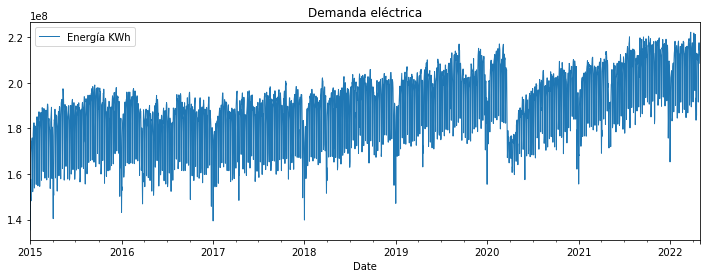

In [935]:
# Gráfico Demanda
# ==============================================================================

fig, ax = plt.subplots(figsize=(12, 4))
demanda['Demanda'].plot(ax=ax, label='Energía KWh', linewidth=1)
ax.set_title('Demanda eléctrica')
ax.legend();

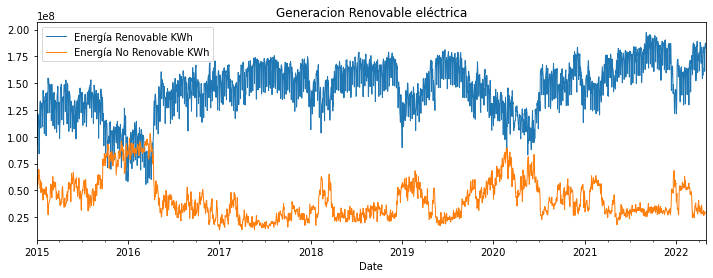

In [1019]:
# Gráfico Generación Renovable
# ==============================================================================

fig, ax = plt.subplots(figsize=(12, 4))
generacion_renovable['total_generacion'].plot(ax=ax, label='Energía Renovable KWh', linewidth=1)
generacion_no_renovable['total_generacion'].plot(ax=ax, label='Energía No Renovable KWh', linewidth=1)

ax.set_title('Generacion Renovable eléctrica')
ax.legend();

Observe que para la gráfica de demanda, en el periodo de pandemia se nota claramente un comportamiento atípico.

Por otro lado, se puede notar que de la gráfica de generación, la generación no renovable funciona como un estabilizador respecto a la demanda, ya que cuando hay picos negativos de generación renovable, se produce más energía no renovable para cubrir las necesidades.

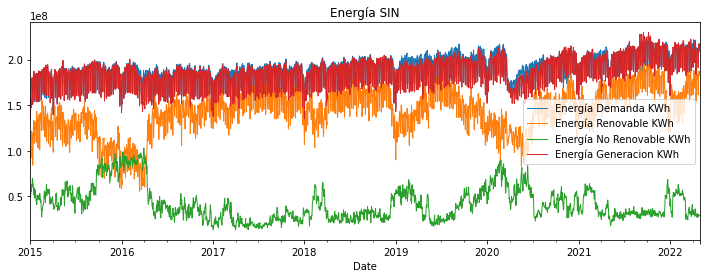

In [1020]:
# Gráfico Comportamiento Conjuntos
# ==============================================================================

fig, ax = plt.subplots(figsize=(12, 4))
demanda['Demanda'].plot(ax=ax, label='Energía Demanda KWh', linewidth=1)
generacion_renovable['total_generacion'].plot(ax=ax, label='Energía Renovable KWh', linewidth=1)
generacion_no_renovable['total_generacion'].plot(ax=ax, label='Energía No Renovable KWh', linewidth=1)
(generacion_no_renovable['total_generacion'] + generacion_renovable['total_generacion']).plot(ax=ax, 
                                                                                              label='Energía Generacion KWh', 
                                                                                              linewidth=1)

ax.set_title('Energía SIN')
ax.legend();

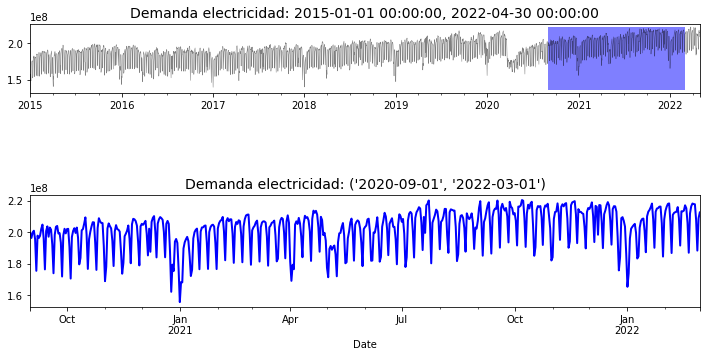

In [938]:
# Gráfico serie temporal con zoom
# ==============================================================================
zoom = ('2020-09-01','2022-03-01')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

demanda['Demanda'].plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)


min_y = min(demanda['Demanda'])
max_y = max(demanda['Demanda'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

demanda.loc[zoom[0]: zoom[1]]['Demanda'].plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Demanda electricidad: {demanda.index.min()}, {demanda.index.max()}', fontsize=14)
zoom_ax.set_title(f'Demanda electricidad: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

Se puede observar que existe una ciclicidad anual marcada por una caída en el mes de enero. En el mes de mayo de esta última gráfica, se puede además observar una caída por lo ocurrido en Mayo con el paro nacional.

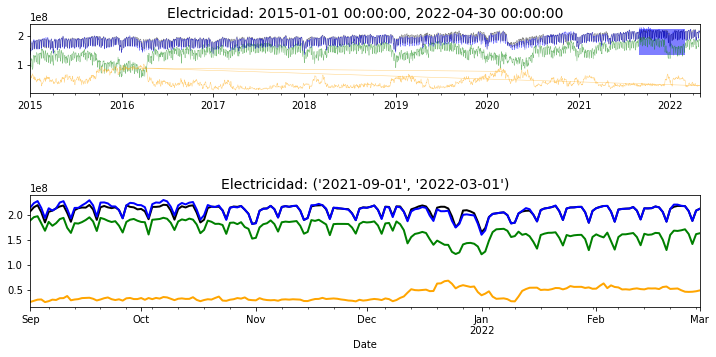

In [939]:
# Gráfico General con zoom
# ==============================================================================
zoom = ('2021-09-01','2022-03-01')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

demanda['Demanda'].plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
generacion_renovable['total_generacion'].plot(ax=main_ax, c='green', alpha=0.5, linewidth=0.5)
generacion_no_renovable['total_generacion'].plot(ax=main_ax, c='orange', alpha=0.5, linewidth=0.5)
(generacion_no_renovable['total_generacion'] + generacion_renovable['total_generacion']).plot(ax=main_ax, 
                                                                                              c='blue', 
                                                                                              alpha=0.5, 
                                                                                              linewidth=0.5)
min_y = min(demanda['Demanda'])
max_y = max(demanda['Demanda'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

demanda.loc[zoom[0]: zoom[1]]['Demanda'].plot(ax=zoom_ax, color='black', linewidth=2)
generacion_renovable.loc[zoom[0]: zoom[1]]['total_generacion'].plot(ax=zoom_ax, color='green', linewidth=2)
generacion_no_renovable.loc[zoom[0]: zoom[1]]['total_generacion'].plot(ax=zoom_ax, color='orange', linewidth=2)
(generacion_no_renovable['total_generacion'] + generacion_renovable['total_generacion']).loc[zoom[0]: zoom[1]].plot(ax=zoom_ax, color='blue', linewidth=2)


main_ax.set_title(f'Electricidad: {demanda.index.min()}, {demanda.index.max()}', fontsize=14)
zoom_ax.set_title(f'Electricidad: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

Ahora, haciendo zoom a las series agregadas, se observa que la demanda y la generacion total son muy similares, esto es puesto que la demanda no cubierta por la generación de energías renovables debe ser cubierta con energías no renovables, dando lugar a que la suma de estas dos últimas cubra la demanda total.

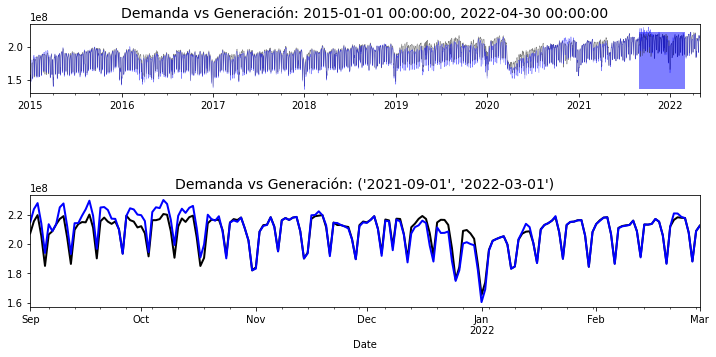

In [940]:
# Gráfico Demanda vs Generación con zoom
# ==============================================================================
zoom = ('2021-09-01','2022-03-01')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

demanda['Demanda'].plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)

(generacion_no_renovable['total_generacion'] + generacion_renovable['total_generacion']).plot(ax=main_ax, 
                                                                                              c='blue', 
                                                                                              alpha=0.5, 
                                                                                              linewidth=0.5)
min_y = min(demanda['Demanda'])
max_y = max(demanda['Demanda'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

demanda.loc[zoom[0]: zoom[1]]['Demanda'].plot(ax=zoom_ax, color='black', linewidth=2)
(generacion_no_renovable['total_generacion'] + generacion_renovable['total_generacion']).loc[zoom[0]: zoom[1]].plot(ax=zoom_ax, color='blue', linewidth=2)


main_ax.set_title(f'Demanda vs Generación: {demanda.index.min()}, {demanda.index.max()}', fontsize=14)
zoom_ax.set_title(f'Demanda vs Generación: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

Notece que ambas series son muy cercanas, con periodos donde la generación es mayor a la demanda y viceversa.

**Todo esto además de la clara estacionalidad semanal que presenta ambas series**.

##### Estacionalidad anual, mensual y diaria para la Demanda

In [941]:
demanda.reset_index(inplace=True)
demanda['year'] = demanda['Date'].apply(lambda x: x.year)
demanda['month'] = demanda['Date'].apply(lambda x: x.month)
demanda['day'] = demanda['Date'].apply(lambda x: x.day)

demanda.set_index('Date', inplace=True)

In [942]:
demanda

,Demanda,year,month,day
Date,,,,
2015-01-01,1.354979e+08,2015,1,1
2015-01-02,1.571844e+08,2015,1,2
2015-01-03,1.575884e+08,2015,1,3
2015-01-04,1.482300e+08,2015,1,4
2015-01-05,1.694005e+08,2015,1,5
...,...,...,...,...
2022-04-26,2.157302e+08,2022,4,26
2022-04-27,2.175944e+08,2022,4,27
2022-04-28,2.142974e+08,2022,4,28


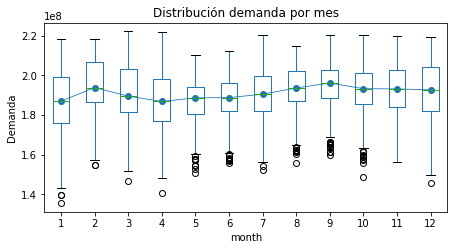

In [943]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))

demanda.boxplot(column='Demanda', by='month', ax=ax,)
demanda.groupby('month')['Demanda'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demanda')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

Se observa que existe estacionalidad anual leve, quiere decir que no es muy marcada, aunque podría ser útil tomar ventaja de este resultado para el entrenamiento del modelo (como variable predictora). También se observa que existen caídas en mayo, junio, agosto, septiembre y diciembre, las cuales se pudieron ver afectadas significativamente por la pandemia. Los valores más altos de la mediana son febrero y septiembre, y el valor más bajo, como se vio anteriormente, es enero.

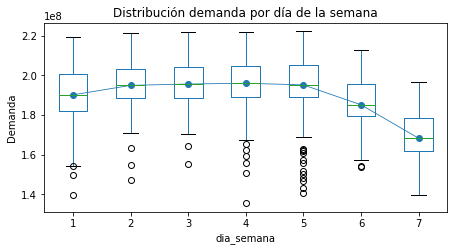

In [944]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
demanda['dia_semana'] = demanda.index.to_series().dt.dayofweek + 1
demanda.boxplot(column='Demanda', by='dia_semana', ax=ax)
demanda.groupby('dia_semana')['Demanda'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demanda')
ax.set_title('Distribución demanda por día de la semana')
fig.suptitle('');

Se observa claramente que existe una estacionalidad bastante marcada, donde los días de fin de semana (sábado y domingo) presenta los valores más bajos de la semana, seguidos por el día lunes. El día viernes presenta caídas significativas como valores atípicos, lo que indica que para ese día frecuentemente se evidencia que caerá la demanda para los 3 días posteriores.

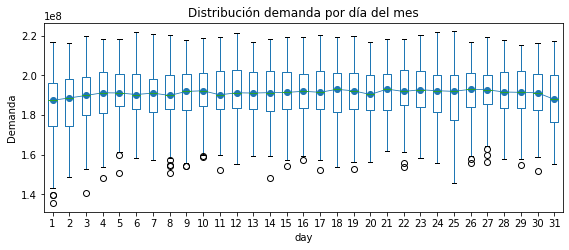

In [945]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
demanda.boxplot(column='Demanda', by='day', ax=ax)
demanda.groupby('day')['Demanda'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demanda')
ax.set_title('Distribución demanda por día del mes')
fig.suptitle('');

Se observe que para el día del mes no se presenta una estacionalidad marcada, únicamente para los valores inicial y final del mes la mediana cae. Sin embargo, dada la variabilidad de los rangos maximos de cada día, se considerará esta variable para el entrenamiento del modelo.

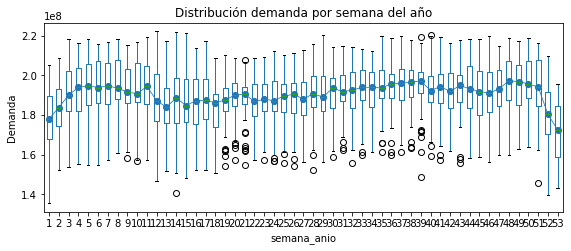

In [946]:
# Gráfico boxplot para estacionalidad semana del año
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
demanda['semana_anio'] = demanda.index.to_series().dt.week
demanda.boxplot(column='Demanda', by='semana_anio', ax=ax)
demanda.groupby('semana_anio')['Demanda'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demanda')
ax.set_title('Distribución demanda por semana del año')
fig.suptitle('');

Existe una estacionalidad evidente en este indicador, las primeras y últimas semanas del año son menos exigentes energeticamente hablando, aunque para el mes de febrero se evidencia un crecimiento que cae en marzo y se recupera gradualmente en el año.

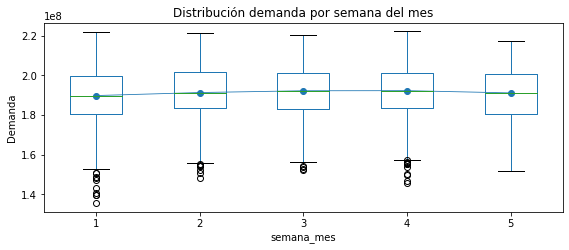

In [947]:
# Gráfico boxplot para estacionalidad semana del mes
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
demanda['semana_mes'] = (demanda.index.to_series().dt.day - 1) // 7 + 1
demanda.boxplot(column='Demanda', by='semana_mes', ax=ax)
demanda.groupby('semana_mes')['Demanda'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demanda')
ax.set_title('Distribución demanda por semana del mes')
fig.suptitle('');

Para este resultado, es claro que no existe estacionalidad, lo que podría resultar en errores incluir esta variable en el entrenamiento. Por lo que no se incluirá.

##### Estacionalidad anual, mensual y diaria para la generación renovable

In [948]:
generacion_renovable.reset_index(inplace=True)
generacion_renovable['year'] = generacion_renovable['Date'].apply(lambda x: x.year)
generacion_renovable['month'] = generacion_renovable['Date'].apply(lambda x: x.month)
generacion_renovable['day'] = generacion_renovable['Date'].apply(lambda x: x.day)

generacion_renovable.set_index('Date', inplace=True)

In [949]:
generacion_renovable

Values_Type,EOLICA,HIDRAULICA,SOLAR,total_generacion,year,month,day
Date,,,,,,,
2015-01-01,278396.97,8.541364e+07,0.00,8.569203e+07,2015,1,1
2015-01-02,302720.35,1.049817e+08,0.00,1.052844e+08,2015,1,2
2015-01-03,298578.90,1.038659e+08,0.00,1.041644e+08,2015,1,3
2015-01-04,225874.82,9.211786e+07,0.00,9.234374e+07,2015,1,4
2015-01-05,75515.96,1.121426e+08,0.00,1.122181e+08,2015,1,5
...,...,...,...,...,...,...,...
2022-04-26,15856.38,1.852768e+08,1179803.30,1.864724e+08,2022,4,26
2022-04-27,0.00,1.870622e+08,407657.93,1.874699e+08,2022,4,27
2022-04-28,27263.51,1.842934e+08,900995.31,1.852216e+08,2022,4,28


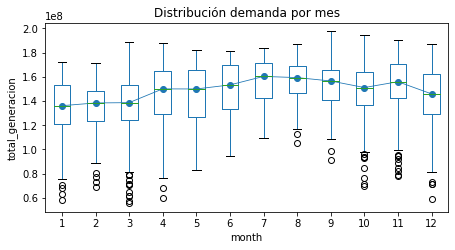

In [950]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))

generacion_renovable.boxplot(column='total_generacion', by='month', ax=ax,)
generacion_renovable.groupby('month')['total_generacion'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('total_generacion')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

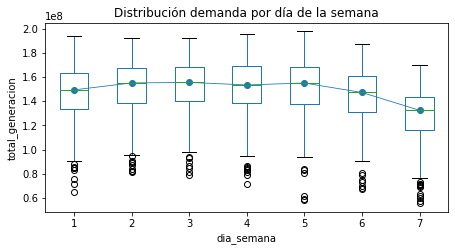

In [951]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
generacion_renovable['dia_semana'] = generacion_renovable.index.to_series().dt.dayofweek + 1
generacion_renovable.boxplot(column='total_generacion', by='dia_semana', ax=ax)
generacion_renovable.groupby('dia_semana')['total_generacion'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('total_generacion')
ax.set_title('Distribución demanda por día de la semana')
fig.suptitle('');

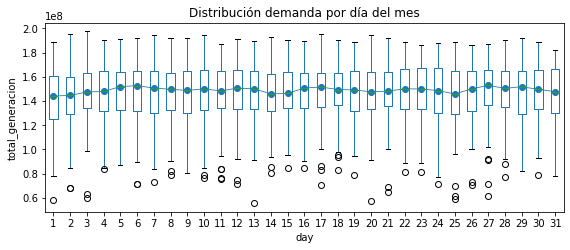

In [952]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
generacion_renovable.boxplot(column='total_generacion', by='day', ax=ax)
generacion_renovable.groupby('day')['total_generacion'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('total_generacion')
ax.set_title('Distribución demanda por día del mes')
fig.suptitle('');

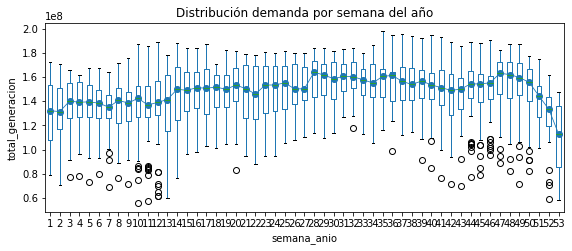

In [953]:
# Gráfico boxplot para estacionalidad semana del año
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
generacion_renovable['semana_anio'] = generacion_renovable.index.to_series().dt.week
generacion_renovable.boxplot(column='total_generacion', by='semana_anio', ax=ax)
generacion_renovable.groupby('semana_anio')['total_generacion'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('total_generacion')
ax.set_title('Distribución demanda por semana del año')
fig.suptitle('');

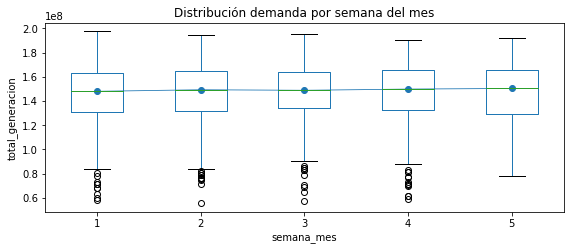

In [954]:
# Gráfico boxplot para estacionalidad semana del mes
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
generacion_renovable['semana_mes'] = (generacion_renovable.index.to_series().dt.day - 1) // 7 + 1
generacion_renovable.boxplot(column='total_generacion', by='semana_mes', ax=ax)
generacion_renovable.groupby('semana_mes')['total_generacion'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('total_generacion')
ax.set_title('Distribución demanda por semana del mes')
fig.suptitle('');

Los resultados para la generación renovable son similares a la demanda en cuanto a la existencia de estacionalidad, es decir, para la única que no se evidencia una estacionalidad es para la semana del mes, al igual que en demanda. Sin embargo, las estacionalidades evidenciadas para las demás variables respetan cada una su comportamiento.

Para el resultado de día de la semana se sigue evidenciando que existe un comportamiento estacional de caída de los últimos días de la semana. Este resultado es de gran importancia ya que permitirán crear variables rezagadas para los modelos que den mayor explicabilidad y precisión del resultado.

##### Días Festivos

Se observa ahora la influencia de los días festivos o feriados en el comportamiento de las series. Primero, creamos la variable utilizando la siguiente pieza de código:

Creditos: Lema Daniel  
https://es.linkedin.com/pulse/calendario-con-festivos-colombianos-en-python-lema-daniel

In [955]:
# Días Festivos
# ============================================================================================

from pandas.tseries.holiday import *
from pandas.tseries.offsets import CustomBusinessDay


def strict_next_monday(dt: datetime) -> datetime:
    """
    Si el festivo cae en un día diferente a lunes, se corre al próximo lunes
    """
    if dt.weekday() > 0:
        return dt + timedelta(7-dt.weekday())
    return dt


class ColombianBusinessCalendar(AbstractHolidayCalendar):
    rules = [
        # festivos fijos
        Holiday('Año nuevo', month=1, day=1),
        Holiday('Día del trabajo', month=5, day=1),
        Holiday('Día de la independencia', month=7, day=20),
        Holiday('Batalla de Boyacá', month=8, day=7),
        Holiday('Inmaculada Concepción', month=12, day=8),
        Holiday('Navidad', month=12, day=25),
        # festivos relativos a la pascua
        Holiday('Jueves santo', month=1, day=1, offset=[Easter(), Day(-3)]),
        Holiday('Viernes santo', month=1, day=1, offset=[Easter(), Day(-2)]),
        Holiday('Ascención de Jesús', month=1, day=1, offset=[Easter(), Day(43)]),
        Holiday('Corpus Christi', month=1, day=1, offset=[Easter(), Day(64)]),
        Holiday('Sagrado Corazón de Jesús', month=1, day=1, offset=[Easter(), Day(71)]),
        # festivos desplazables (Emiliani)
        Holiday('Epifanía del señor', month=1, day=6, observance=strict_next_monday),
        Holiday('Día de San José', month=3, day=19, observance=strict_next_monday),
        Holiday('San Pedro y San Pablo', month=6, day=29, observance=strict_next_monday),
        Holiday('Asunción de la Virgen', month=8, day=15, observance=strict_next_monday),
        Holiday('Día de la raza', month=10, day=12, observance=strict_next_monday),
        Holiday('Todos los santos', month=11, day=1, observance=strict_next_monday),
        Holiday('Independencia de Cartagena', month=11, day=11, observance=strict_next_monday)
    ]
    
Colombian_BD = CustomBusinessDay(calendar=ColombianBusinessCalendar())

holidays = np.array(Colombian_BD.holidays) 
holidays = holidays[(holidays >= dt.date(2015, 1, 1)) & (holidays < dt.date(2022, 5, 1))]

In [956]:
demanda['holidays'] = np.isin(demanda.reset_index()['Date'], holidays)
generacion_renovable['holidays'] = np.isin(generacion_renovable.reset_index()['Date'], holidays)

Adicionalmente, dado que para los analisis de día de semana se notó una importancia en sábado y domingo, se crearan dos variables para estos días.

In [957]:
range_dates = pd.date_range('2015-01-01', '2022-05-01', freq='D').to_series()
days = range_dates.dt.dayofweek

saturdays = days[days == 5]
sundays = days[days == 6]

demanda['saturdays'] = np.isin(demanda.reset_index()['Date'], saturdays.index)
demanda['sundays'] = np.isin(demanda.reset_index()['Date'], sundays.index)
generacion_renovable['saturdays'] = np.isin(generacion_renovable.reset_index()['Date'], saturdays.index)
generacion_renovable['sundays'] = np.isin(generacion_renovable.reset_index()['Date'], sundays.index)

In [958]:
demanda

,Demanda,year,month,day,dia_semana,semana_anio,semana_mes,holidays,saturdays,sundays
Date,,,,,,,,,,
2015-01-01,1.354979e+08,2015,1,1,4,1,1,True,False,False
2015-01-02,1.571844e+08,2015,1,2,5,1,1,False,False,False
2015-01-03,1.575884e+08,2015,1,3,6,1,1,False,True,False
2015-01-04,1.482300e+08,2015,1,4,7,1,1,False,False,True
2015-01-05,1.694005e+08,2015,1,5,1,2,1,False,False,False
...,...,...,...,...,...,...,...,...,...,...
2022-04-26,2.157302e+08,2022,4,26,2,17,4,False,False,False
2022-04-27,2.175944e+08,2022,4,27,3,17,4,False,False,False
2022-04-28,2.142974e+08,2022,4,28,4,17,4,False,False,False


In [959]:
generacion_renovable

Values_Type,EOLICA,HIDRAULICA,SOLAR,total_generacion,year,month,day,dia_semana,semana_anio,semana_mes,holidays,saturdays,sundays
Date,,,,,,,,,,,,,
2015-01-01,278396.97,8.541364e+07,0.00,8.569203e+07,2015,1,1,4,1,1,True,False,False
2015-01-02,302720.35,1.049817e+08,0.00,1.052844e+08,2015,1,2,5,1,1,False,False,False
2015-01-03,298578.90,1.038659e+08,0.00,1.041644e+08,2015,1,3,6,1,1,False,True,False
2015-01-04,225874.82,9.211786e+07,0.00,9.234374e+07,2015,1,4,7,1,1,False,False,True
2015-01-05,75515.96,1.121426e+08,0.00,1.122181e+08,2015,1,5,1,2,1,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,15856.38,1.852768e+08,1179803.30,1.864724e+08,2022,4,26,2,17,4,False,False,False
2022-04-27,0.00,1.870622e+08,407657.93,1.874699e+08,2022,4,27,3,17,4,False,False,False
2022-04-28,27263.51,1.842934e+08,900995.31,1.852216e+08,2022,4,28,4,17,4,False,False,False


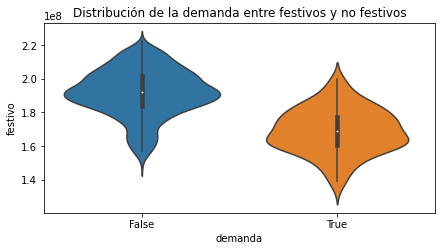

In [960]:
# Grafico violinplot
# ==============================================================================

# Se hará para un año especifico para poder obtener un gráfico coherente
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))

sns.violinplot(ax=ax, x = "holidays", y = "Demanda", data = demanda, kind = "violin")

ax.set_title('Distribución de la demanda entre festivos y no festivos')
ax.set_xlabel('demanda')
ax.set_ylabel('festivo');

Se observa claramente que para los días festivos el valor de demanda es menor que para los días regulares, por lo que se puede concluir que esta variable puede ser de importancia para la predicción.

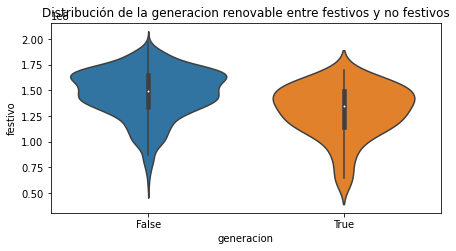

In [961]:
# Grafico violinplot
# ==============================================================================

# Se hará para un año especifico para poder obtener un gráfico coherente
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))

sns.violinplot(ax=ax, x = "holidays", y = "total_generacion", data = generacion_renovable, kind = "violin")

ax.set_title('Distribución de la generacion renovable entre festivos y no festivos')
ax.set_xlabel('generacion')
ax.set_ylabel('festivo');

#### Análisis de autocorrelación

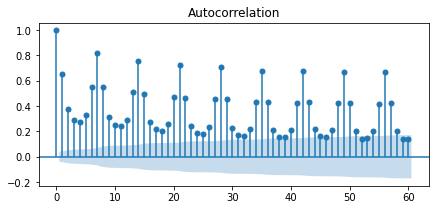

In [962]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(demanda['Demanda'], ax=ax, lags=60)
plt.show()

El grafico respalda las conclusiones que se han obtenido con los análisis anteriores. Puede observarse que hay una alta correlación cada 7 días, lo cual corresponde a la estacional vista en día de la semana, además, el valor concreto del día anterior esta altamente correlacionado, lo que puede resultar en un valor explicativo importante para el modelo. 

Veamos ahora con un periodo de retardo mayor

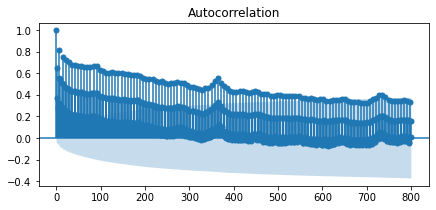

In [963]:
# Gráfico autocorrelación anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(demanda['Demanda'], ax=ax, lags=800)
plt.show()

Aunque la gráfica es difícil, se nota que para el lag correspondiente a 1 año hay una correlación significativa, por lo que este lag podría ser de utilidad como variable explicativa

Para generacion renovable

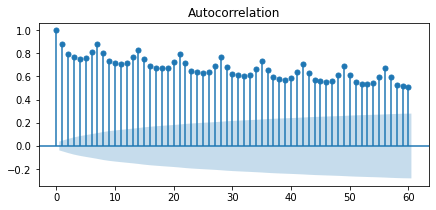

In [964]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(generacion_renovable['total_generacion'], ax=ax, lags=60)
plt.show()

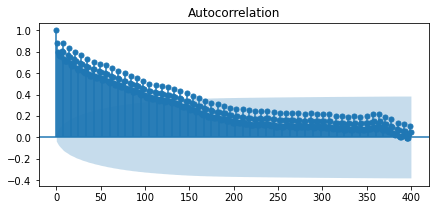

In [965]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(generacion_renovable['total_generacion'], ax=ax, lags=400)
plt.show()

El resultado es distinto que para demanda. No se evidencia una correlación tan clara en los lags semanales, aunque sigue existiendo mayor correlación para estos. Mientras que para la correlación anual no se nota la significancia de este lag (365).

Ahora veamos la autocorrelación parcial

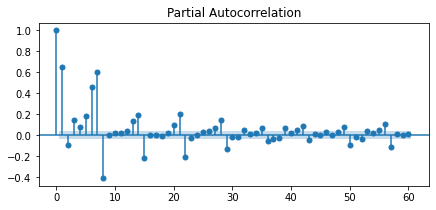

In [966]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(demanda['Demanda'], ax=ax, lags=60)
plt.show()

Vemos que los lag 1, 6, 7 tienen una correlacion positiva alta, y para el 8 tenemos una correlación negativa significativa.

Ahora para generación.

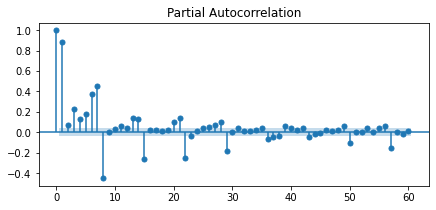

In [967]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(generacion_renovable['total_generacion'], ax=ax, lags=60)
plt.show()

El resultado es similar al de demanda.

### Extracción y transformación de variables

En la exploración, se crearon distintas variables y se agregó un fundamento de análisis a cada uno de estas para considerarlas como variables predictoras para el modelo. La mayoría de estas resultan de interes, aunque la única que no presenta un comportamiento relevante es *semana del mes*.

Al proceso de creación de estas variable se le conoce también como extracción de variables, ya que usamos un conocimiento previo de la información (en este caso la fecha) para obtenerlas.

Sinteticemos entonces lo realizado anteriormente. Se crearon 9 variables:

- year
- month
- day (dia del mes)
- dia_semana
- semana_anio
- semana_mes
- holidays
- saturdays
- sundays

de estas, la única que no es de interés es *semana_mes*. Por otro lado, se analizaron los retardos, encontrando de interés los retardos semanales (Cada 7 días), el lag 1 (día anterior), el lag de 365 días (valor del año anterior) y algunos otros como los que estan entre el 6 y 8 lag. Por lo que, adicionando estas variables, se tiene un conjunto de variables predictoras utiles para modelos de machine learning tales como los árboles de decisión. En el modelamiento, se utilizará, entre otras técnicas, una de enfoque de árboles de decisión debido a los resultados obtenidos en la exploración y extracción de variables.


Por otro lado, las variables ciclicas que se analizaron anteriormente, pierden sentido al presentarlas como variables númericas, por ejemplo, para la variable de dia de la semana, el día 1 no necesariamente es el más alejado del día 7, sin embargo bajo una métrica usual como la euclidiana estos dos valores son los más alejados para dicha variable. Por tanto, se lleva a cabo una transformación utilizando el seno y coseno del circulo que describen estas variables.

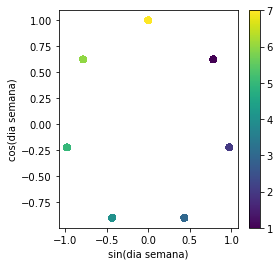

In [968]:
# Transformación seno-coseno de la variable dia_semana
# ==============================================================================
demanda['dia_semana_sin'] = np.sin(demanda['dia_semana'] / 7 * 2 * np.pi)
demanda['dia_semana_cos'] = np.cos(demanda['dia_semana'] / 7 * 2 * np.pi)

# Representación de la transformación seno-coseno de la variable hora
# ==============================================================================
fig, ax = plt.subplots(figsize=(4, 4))
sp = ax.scatter(demanda["dia_semana_sin"], demanda["dia_semana_cos"], c=demanda["dia_semana"])
ax.set(
    xlabel="sin(dia semana)",
    ylabel="cos(dia semana)",
)
_ = fig.colorbar(sp)


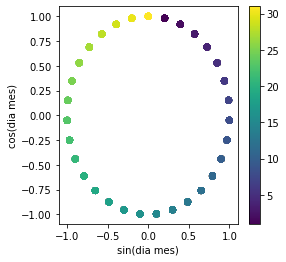

In [969]:
# Transformación seno-coseno de la variable dia_mes
# ==============================================================================
demanda['day_sin'] = np.sin(demanda['day'] / 31 * 2 * np.pi)
demanda['day_cos'] = np.cos(demanda['day'] / 31 * 2 * np.pi)

# Representación de la transformación seno-coseno de la variable hora
# ==============================================================================
fig, ax = plt.subplots(figsize=(4, 4))
sp = ax.scatter(demanda["day_sin"], demanda["day_cos"], c=demanda["day"])
ax.set(
    xlabel="sin(dia mes)",
    ylabel="cos(dia mes)",
)
_ = fig.colorbar(sp)


In [970]:
# Transformación seno-coseno 
# ==============================================================================
demanda['month_sin'] = np.sin(demanda['month'] / 52 * 2 * np.pi)
demanda['month_cos'] = np.cos(demanda['month'] / 52 * 2 * np.pi)

demanda['semana_anio_sin'] = np.sin(demanda['semana_anio'] / 52 * 2 * np.pi)
demanda['semana_anio_cos'] = np.cos(demanda['semana_anio'] / 52 * 2 * np.pi)


In [971]:
generacion_renovable['dia_semana_sin'] = np.sin(generacion_renovable['dia_semana'] / 7 * 2 * np.pi)
generacion_renovable['dia_semana_cos'] = np.cos(generacion_renovable['dia_semana'] / 7 * 2 * np.pi)

generacion_renovable['day_sin'] = np.sin(generacion_renovable['day'] / 31 * 2 * np.pi)
generacion_renovable['day_cos'] = np.cos(generacion_renovable['day'] / 31 * 2 * np.pi)

generacion_renovable['month_sin'] = np.sin(generacion_renovable['month'] / 52 * 2 * np.pi)
generacion_renovable['month_cos'] = np.cos(generacion_renovable['month'] / 52 * 2 * np.pi)

generacion_renovable['semana_anio_sin'] = np.sin(generacion_renovable['semana_anio'] / 52 * 2 * np.pi)
generacion_renovable['semana_anio_cos'] = np.cos(generacion_renovable['semana_anio'] / 52 * 2 * np.pi)


In [972]:
generacion_renovable

Values_Type,EOLICA,HIDRAULICA,SOLAR,total_generacion,year,month,day,dia_semana,semana_anio,semana_mes,...,saturdays,sundays,dia_semana_sin,dia_semana_cos,day_sin,day_cos,month_sin,month_cos,semana_anio_sin,semana_anio_cos
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,278396.97,8.541364e+07,0.00,8.569203e+07,2015,1,1,4,1,1,...,False,False,-4.338837e-01,-0.900969,0.201299,0.979530,0.120537,0.992709,0.120537,0.992709
2015-01-02,302720.35,1.049817e+08,0.00,1.052844e+08,2015,1,2,5,1,1,...,False,False,-9.749279e-01,-0.222521,0.394356,0.918958,0.120537,0.992709,0.120537,0.992709
2015-01-03,298578.90,1.038659e+08,0.00,1.041644e+08,2015,1,3,6,1,1,...,True,False,-7.818315e-01,0.623490,0.571268,0.820763,0.120537,0.992709,0.120537,0.992709
2015-01-04,225874.82,9.211786e+07,0.00,9.234374e+07,2015,1,4,7,1,1,...,False,True,-2.449294e-16,1.000000,0.724793,0.688967,0.120537,0.992709,0.120537,0.992709
2015-01-05,75515.96,1.121426e+08,0.00,1.122181e+08,2015,1,5,1,2,1,...,False,False,7.818315e-01,0.623490,0.848644,0.528964,0.120537,0.992709,0.239316,0.970942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,15856.38,1.852768e+08,1179803.30,1.864724e+08,2022,4,26,2,17,4,...,False,False,9.749279e-01,-0.222521,-0.848644,0.528964,0.464723,0.885456,0.885456,-0.464723
2022-04-27,0.00,1.870622e+08,407657.93,1.874699e+08,2022,4,27,3,17,4,...,False,False,4.338837e-01,-0.900969,-0.724793,0.688967,0.464723,0.885456,0.885456,-0.464723
2022-04-28,27263.51,1.842934e+08,900995.31,1.852216e+08,2022,4,28,4,17,4,...,False,False,-4.338837e-01,-0.900969,-0.571268,0.820763,0.464723,0.885456,0.885456,-0.464723


**Nota:** *Sin embargo, testearemos el modelo solo utilizando esta variables en cuestión, transformadas vs no transformadas, para verificar que este modelo en particular funciona mejor para las variables sin transformar.*


### Modelación

Se modelará a partir de tres (3) modelos, una de series de tiempo que usaremos como modelo de referencia, una enfoque de redes neuronales, y un enfoque de *gradient boosting*, donde el weak learner es generalmente un bosque aleatorio.

Para la modelación, se hará uso mayormente de la librería *skforecast*, la cual automatiza la mayoría de los procesos necesarios para hacer predicciones, así como la validación de modelos de machine learning en problemas de forecasting. Además, para el *gradient boosting* se utilizará la libreria XGBoost.

Para la validación, la librería *skforecast* desarrolla funciones para aplicar estrategias específicas como backtesting, walk-forward validation o time series cross-validation. El uso de la validación cruzada tradicional no aplica en estos casos.

Se definen las variables exogenas 

In [973]:
# Se seleccionan todas las variables exógenas
variables_exogenas = ['year', 'month', 'day', 'dia_semana', 'semana_anio',
                      'semana_mes', 'holidays', 'saturdays', 'sundays']

variables_exogenas_transformadas = ['year', 'holidays', 'saturdays', 'sundays',
                                    'dia_semana_sin', 'dia_semana_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
                                    'semana_anio_sin', 'semana_anio_cos']


In [974]:
variables_exogenas_transformadas

['year',
 'holidays',
 'saturdays',
 'sundays',
 'dia_semana_sin',
 'dia_semana_cos',
 'day_sin',
 'day_cos',
 'month_sin',
 'month_cos',
 'semana_anio_sin',
 'semana_anio_cos']

#### Separación train, test, validation

In [975]:
# Separación datos train-val-test
# ==============================================================================
fin_train = '2021-01-01'
fin_validacion = '2022-01-01'
demanda_train = demanda.loc[: fin_train, :]
demanda_val   = demanda.loc[fin_train:fin_validacion, :]
demanda_test  = demanda.loc[fin_validacion:, :]

print(f"Fechas train      : {demanda_train.index.min()} --- {demanda_train.index.max()}  (n={len(demanda_train)})")
print(f"Fechas validacion : {demanda_val.index.min()} --- {demanda_val.index.max()}  (n={len(demanda_val)})")
print(f"Fechas test       : {demanda_test.index.min()} --- {demanda_test.index.max()}  (n={len(demanda_test)})")

Fechas train      : 2015-01-01 00:00:00 --- 2021-01-01 00:00:00  (n=2193)
Fechas validacion : 2021-01-01 00:00:00 --- 2022-01-01 00:00:00  (n=366)
Fechas test       : 2022-01-01 00:00:00 --- 2022-04-30 00:00:00  (n=120)


In [976]:
generacion_renovable_train = generacion_renovable.loc[: fin_train, :]
generacion_renovable_val   = generacion_renovable.loc[fin_train:fin_validacion, :]
generacion_renovable_test  = generacion_renovable.loc[fin_validacion:, :]

print(f"Fechas train      : {generacion_renovable_train.index.min()} --- {generacion_renovable_train.index.max()}  (n={len(generacion_renovable_train)})")
print(f"Fechas validacion : {generacion_renovable_val.index.min()} --- {generacion_renovable_val.index.max()}  (n={len(generacion_renovable_val)})")
print(f"Fechas test       : {generacion_renovable_test.index.min()} --- {generacion_renovable_test.index.max()}  (n={len(generacion_renovable_test)})")

Fechas train      : 2015-01-01 00:00:00 --- 2021-01-01 00:00:00  (n=2193)
Fechas validacion : 2021-01-01 00:00:00 --- 2022-01-01 00:00:00  (n=366)
Fechas test       : 2022-01-01 00:00:00 --- 2022-04-30 00:00:00  (n=120)


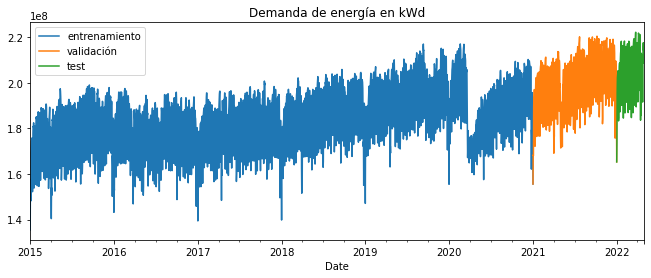

In [977]:
# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
demanda_train['Demanda'].plot(ax=ax, label='entrenamiento')
demanda_val['Demanda'].plot(ax=ax, label='validación')
demanda_test['Demanda'].plot(ax=ax, label='test')
ax.set_title('Demanda de energía en kWd')
ax.legend();

Se crea el predictor por medio de la clase **ForecasterAutoreg** de la librería *skforecast*

In [978]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 31
             )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=123,
             reg_alpha=None, reg_lambda=None, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] 
Window size: 31 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Trai

#### Ajuste de Hiperparametros

In [979]:
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [7, [1, 2, 6, 7, 8, 14, 15, 28, 365], [1,2,7,14,28,365], [1,365], [1,7,365], [1,7,14,365]]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = demanda.loc[:fin_validacion, 'Demanda'],
                        exog               = demanda.loc[:fin_validacion, variables_exogenas],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 30,
                        refit              = False,
                        metric             = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(demanda_train)),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 72


loop lags_grid: 100%|███████████████████████████████████████| 6/6 [01:26<00:00, 14.47s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.035099141292832065



In [980]:
resultados_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.035099,0.1,3.0,500.0
6,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.036092,0.1,3.0,100.0
69,"[1, 7, 14, 365]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.036346,0.1,5.0,500.0
32,"[1, 2, 7, 14, 28, 365]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.036944,0.1,5.0,100.0
56,"[1, 7, 365]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.038025,0.1,5.0,100.0
10,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.038133,0.1,10.0,100.0
68,"[1, 7, 14, 365]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.038559,0.1,5.0,100.0
11,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.038627,0.1,10.0,500.0
8,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.038932,0.1,5.0,100.0
9,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.039242,0.1,5.0,500.0


In [981]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = demanda['Demanda'],
    exog               = demanda[variables_exogenas],
    initial_train_size = len(demanda.loc[:fin_validacion]),
    steps              = 30,
    refit              = False,
    metric             = 'mean_absolute_percentage_error',
    verbose            = False
)

print(f"Error de backtest: {metric}")

Error de backtest: 0.02359751891323661


In [982]:
predicciones['Date'] = demanda_test.index[1:]
predicciones.set_index('Date', inplace=True)

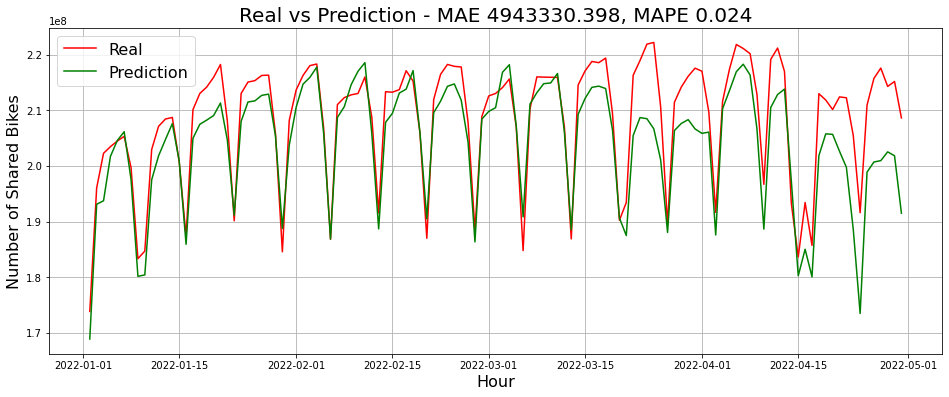

In [983]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

mae = np.round(mean_absolute_error(demanda_test['Demanda'].values[1:], predicciones.values), 3)   
mape = np.round(mean_absolute_percentage_error(demanda_test['Demanda'].values[1:], predicciones.values), 3)


#plot reality vs prediction for the last week of the dataset
fig = plt.figure(figsize=(16,6))
plt.title(f'Real vs Prediction - MAE {mae}, MAPE {mape}', fontsize=20)
plt.plot(demanda_test.iloc[1:]['Demanda'], color='red')
plt.plot(predicciones, color='green')
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Number of Shared Bikes', fontsize=16)
plt.legend(labels=['Real', 'Prediction'], fontsize=16)
plt.grid()
plt.show()

Los resultados presentan un comportamiento satisfactorio, con una metrica MAPE por debajo del 5% de error.

Ahora veamos el resultado utilizando las variables exogenas transformadas

In [984]:
# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [7, [1, 2, 6, 7, 8, 14, 15, 28, 365], [1,2,7,14,28,365], [1,365], [1,7,365], [1,7,14,365]]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = demanda.loc[:fin_validacion, 'Demanda'],
                        exog               = demanda.loc[:fin_validacion, variables_exogenas_transformadas],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 30,
                        refit              = False,
                        metric             = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(demanda_train)),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 72


loop lags_grid: 100%|███████████████████████████████████████| 6/6 [01:26<00:00, 14.39s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   7  14  28 365] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.02868985204402079



In [985]:
resultados_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
31,"[1, 2, 7, 14, 28, 365]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.028690,0.1,3.0,500.0
67,"[1, 7, 14, 365]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.032540,0.1,3.0,500.0
7,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.034095,0.1,3.0,500.0
6,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.034184,0.1,3.0,100.0
30,"[1, 2, 7, 14, 28, 365]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.035274,0.1,3.0,100.0
18,"[1, 2, 6, 7, 8, 14, 15, 28, 365]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.035952,0.1,3.0,100.0
19,"[1, 2, 6, 7, 8, 14, 15, 28, 365]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.036040,0.1,3.0,500.0
66,"[1, 7, 14, 365]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.036405,0.1,3.0,100.0
8,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.036547,0.1,5.0,100.0
56,"[1, 7, 365]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.037407,0.1,5.0,100.0


In [986]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = demanda['Demanda'],
    exog               = demanda[variables_exogenas_transformadas],
    initial_train_size = len(demanda.loc[:fin_validacion]),
    steps              = 30,
    refit              = False,
    metric             = 'mean_absolute_percentage_error',
    verbose            = False
)

print(f"Error de backtest: {metric}")

Error de backtest: 0.032165717774469894


In [987]:
predicciones['Date'] = demanda_test.index[1:]
predicciones.set_index('Date', inplace=True)

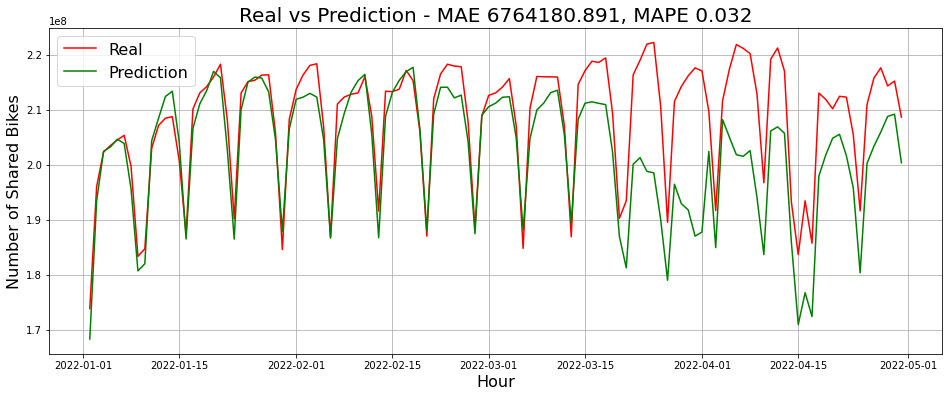

In [988]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

mae = np.round(mean_absolute_error(demanda_test['Demanda'].values[1:], predicciones.values), 3)   
mape = np.round(mean_absolute_percentage_error(demanda_test['Demanda'].values[1:], predicciones.values), 3)


#plot reality vs prediction for the last week of the dataset
fig = plt.figure(figsize=(16,6))
plt.title(f'Real vs Prediction - MAE {mae}, MAPE {mape}', fontsize=20)
plt.plot(demanda_test.iloc[1:]['Demanda'], color='red')
plt.plot(predicciones, color='green')
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Number of Shared Bikes', fontsize=16)
plt.legend(labels=['Real', 'Prediction'], fontsize=16)
plt.grid()
plt.show()

Se observa que, el resultado con las variables transformadas es menos acertado que el resultado con las variables sin transformar. Por esta razón, se decide continuar utilizando las variables sin transformar

#### Limpieza

Es claro que los datos correspondientes a los meses de marzo, abril, mayo, junio y julio de 2020 (e incluso posterior) pertenecen a un comportamiento atípico para cualquier análisis temporal que se lleve a cabo, debido a la pandemia por Covid 19.

Es por esto que, se decide quitar estos valores e imputarlo, para conocer si este comportamiento afecta lo suficiente como para obtener mejores resultado.

Para el tratamiento de estos valores se hará lo siguiente:

1. Se entrena un XGBoost para el periodo de tiempo anterior al mes de marzo de 2020.
2. Se predicen los valores correspondientes a los meses de: 15 de marzo en adelante, abril, mayo, junio, julio.
3. Luego, con el resultado se entrena nuevamente el modelo para los periodos más recientes de 2022.

Se parte la información

In [989]:
# Separación datos train-val-test
# ==============================================================================
inicio_covid = '2020-03-15'
demanda_pre_covid = demanda.loc[: inicio_covid, :]

fin_train_covid = '2019-01-01'
fin_validacion_covid = '2020-02-15'
demanda_train_covid = demanda_pre_covid.loc[: fin_train_covid, :]
demanda_val_covid   = demanda_pre_covid.loc[fin_train_covid:fin_validacion_covid, :]
demanda_test_covid  = demanda_pre_covid.loc[fin_validacion_covid:, :]

print(f"Fechas train      : {demanda_train_covid .index.min()} --- {demanda_train_covid .index.max()}  (n={len(demanda_train_covid )})")
print(f"Fechas validacion : {demanda_val_covid .index.min()} --- {demanda_val_covid .index.max()}  (n={len(demanda_val_covid )})")
print(f"Fechas test       : {demanda_test_covid .index.min()} --- {demanda_test_covid.index.max()}  (n={len(demanda_test_covid )})")

Fechas train      : 2015-01-01 00:00:00 --- 2019-01-01 00:00:00  (n=1462)
Fechas validacion : 2019-01-01 00:00:00 --- 2020-02-15 00:00:00  (n=411)
Fechas test       : 2020-02-15 00:00:00 --- 2020-03-15 00:00:00  (n=30)


Se entrenará con la información anterior a 2019. Se selecciona 2019 como testeo para que la implementación aplique los métodos internos de cross-validation para series de tiempo. Finalmente, se deja el periodo de febrero 15 a marzo 15 como validación.

Se hace lo mismo para generación

In [990]:
generacion_renovable_pre_covid = generacion_renovable.loc[: inicio_covid, :]

generacion_renovable_train_covid = generacion_renovable_pre_covid.loc[: fin_train_covid, :]
generacion_renovable_val_covid   = generacion_renovable_pre_covid.loc[fin_train_covid :fin_validacion_covid, :]
generacion_renovable_test_covid  = generacion_renovable_pre_covid.loc[fin_validacion_covid:, :]

print(f"Fechas train      : {generacion_renovable_train_covid.index.min()} --- {generacion_renovable_train_covid.index.max()}  (n={len(generacion_renovable_train_covid)})")
print(f"Fechas validacion : {generacion_renovable_val_covid.index.min()} --- {generacion_renovable_val_covid.index.max()}  (n={len(generacion_renovable_val_covid)})")
print(f"Fechas test       : {generacion_renovable_test_covid.index.min()} --- {generacion_renovable_test_covid.index.max()}  (n={len(generacion_renovable_test_covid)})")

Fechas train      : 2015-01-01 00:00:00 --- 2019-01-01 00:00:00  (n=1462)
Fechas validacion : 2019-01-01 00:00:00 --- 2020-02-15 00:00:00  (n=411)
Fechas test       : 2020-02-15 00:00:00 --- 2020-03-15 00:00:00  (n=30)


In [991]:
# Crear forecaster
# ==============================================================================
forecaster_covid = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 31
             )


# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [7, [1, 2, 6, 7, 8, 14, 15, 28, 365], [1,2,7,14,28,365], [1,365], [1,7,365], [1,7,14,365]]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster_covid,
                        y                  = demanda_pre_covid.loc[:fin_validacion_covid, 'Demanda'],
                        exog               = demanda_pre_covid.loc[:fin_validacion_covid, variables_exogenas],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 1,
                        refit              = False,
                        metric             = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(demanda_train_covid)),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 72


loop lags_grid: 100%|███████████████████████████████████████| 6/6 [03:08<00:00, 31.50s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 0.022848229662929813



**Nota**: Se utiliza un *step* de 1 día, ya que se requiere que la predicción sea más precisa, y para su objetivo esta decisión es coherente.

In [992]:
resultados_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
6,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.022848,0.1,3.0,100.0
31,"[1, 2, 7, 14, 28, 365]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.023023,0.1,3.0,500.0
55,"[1, 7, 365]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.023038,0.1,3.0,500.0
30,"[1, 2, 7, 14, 28, 365]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.024010,0.1,3.0,100.0
7,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.024122,0.1,3.0,500.0
67,"[1, 7, 14, 365]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.024348,0.1,3.0,500.0
54,"[1, 7, 365]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.025402,0.1,3.0,100.0
43,"[1, 365]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.025473,0.1,3.0,500.0
66,"[1, 7, 14, 365]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.025631,0.1,3.0,100.0
42,"[1, 365]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.025925,0.1,3.0,100.0


In [993]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster         = forecaster_covid,
    y                  = demanda_pre_covid['Demanda'],
    exog               = demanda_pre_covid[variables_exogenas],
    initial_train_size = len(demanda_pre_covid.loc[:fin_validacion_covid]),
    steps              = 1,
    refit              = False,
    metric             = 'mean_absolute_percentage_error',
    verbose            = False
)

print(f"Error de backtest: {metric}")

Error de backtest: 0.010595588965786482


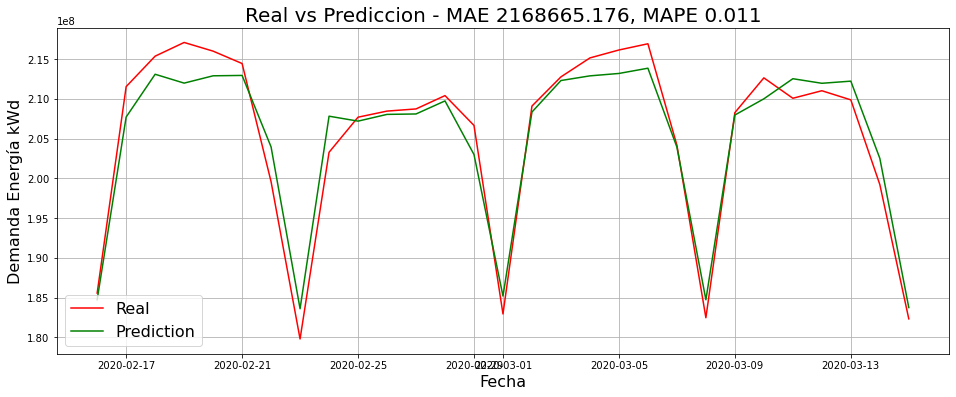

In [994]:
predicciones['Date'] = demanda_test_covid.index[1:]
predicciones.set_index('Date', inplace=True)

mae = np.round(mean_absolute_error(demanda_test_covid['Demanda'].values[1:], predicciones.values), 3)   
mape = np.round(mean_absolute_percentage_error(demanda_test_covid['Demanda'].values[1:], predicciones.values), 3)


#plot reality vs prediction for the last week of the dataset
fig = plt.figure(figsize=(16,6))
plt.title(f'Real vs Prediccion - MAE {mae}, MAPE {mape}', fontsize=20)
plt.plot(demanda_test_covid.iloc[1:]['Demanda'], color='red')
plt.plot(predicciones, color='green')
plt.xlabel('Fecha', fontsize=16)
plt.ylabel('Demanda Energía kWd', fontsize=16)
plt.legend(labels=['Real', 'Prediction'], fontsize=16)
plt.grid()
plt.show()

Como resultado, se observa que la predicción es satisfactoria con un MAPE del 1.1%. Con este modelo se van a predecir los periodos anteriormente mencionados.

In [995]:
fin_covid = '2020-07-31'
demanda_en_covid = demanda.loc[inicio_covid : fin_covid, :]

step = pd.date_range(inicio_covid, fin_covid, freq='D').to_series().shape[0] 

predictions = forecaster_covid.predict(steps=step, exog=demanda_en_covid[variables_exogenas])

In [996]:
predictions = predictions.to_frame()
predictions['Date'] = demanda_en_covid.index
predictions.set_index('Date', inplace=True)

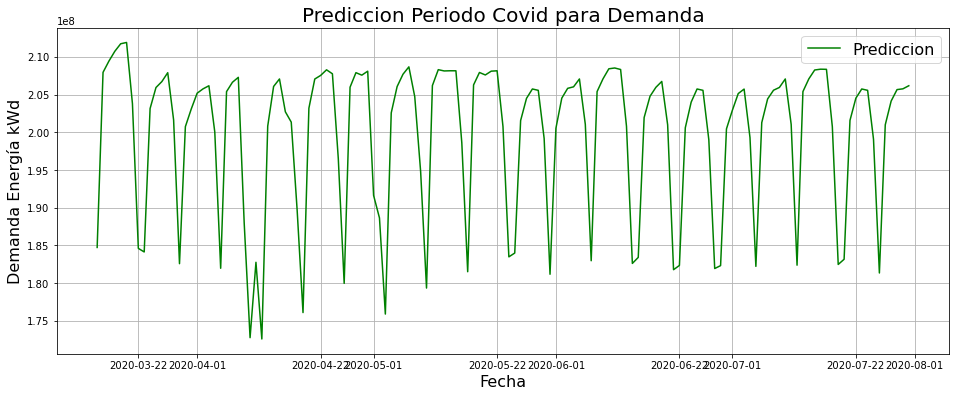

In [997]:
#plot reality vs prediction for the last week of the dataset
fig = plt.figure(figsize=(16,6))
plt.title(f'Prediccion Periodo Covid para Demanda', fontsize=20)
plt.plot(predictions, color='green')
plt.xlabel('Fecha', fontsize=16)
plt.ylabel('Demanda Energía kWd', fontsize=16)
plt.legend(labels=['Prediccion'], fontsize=16)
plt.grid()
plt.show()

Ahora, agregamos esta información a los datos reales y se observa la nueva información

In [998]:
demanda_corregida = demanda.copy()
periodo_covid = pd.date_range(inicio_covid, fin_covid, freq='D')
demanda_corregida.loc[periodo_covid, 'Demanda'] = predictions['pred']

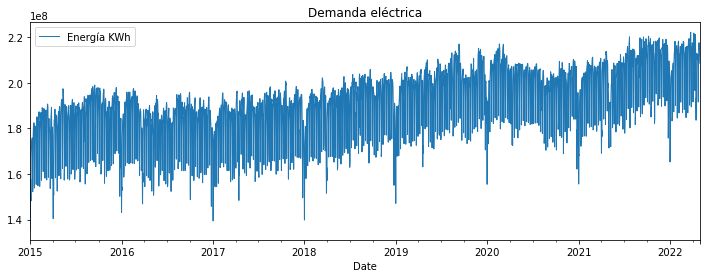

In [999]:
# Gráfico Demanda CORREGIDA
# ==============================================================================

fig, ax = plt.subplots(figsize=(12, 4))
demanda_corregida['Demanda'].plot(ax=ax, label='Energía KWh', linewidth=1)

ax.set_title('Demanda eléctrica')
ax.legend();

Se realiza el mismo procedimiento para generación

In [1000]:
# Crear forecaster
# ==============================================================================
forecaster_covid_generacion = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 31
             )


# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [8, [1, 2, 6, 7, 8, 14, 15, 28, 365], [1,2,7,14,28,365], [1,365], [1,7,365], [1,7,14,365]]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster_covid_generacion,
                        y                  = generacion_renovable_pre_covid.loc[:fin_validacion_covid, 'total_generacion'],
                        exog               = generacion_renovable_pre_covid.loc[:fin_validacion_covid, variables_exogenas],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 1,
                        refit              = False,
                        metric             = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(generacion_renovable_train_covid)),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 72


loop lags_grid: 100%|███████████████████████████████████████| 6/6 [03:10<00:00, 31.70s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7 8] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.030255627421164485



In [1011]:
resultados_grid.head(10)

,lags,params,metric,gamma,lambda,learning_rate,max_depth,n_estimators
403,"[1, 2, 7, 14, 28, 365]","{'gamma': 0.2, 'lambda': 0.4, 'learning_rate':...",0.025524,0.2,0.4,0.05,3.0,400.0
499,"[1, 2, 7, 14, 28, 365]","{'gamma': 0.6, 'lambda': 0.4, 'learning_rate':...",0.025524,0.6,0.4,0.05,3.0,400.0
498,"[1, 2, 7, 14, 28, 365]","{'gamma': 0.6, 'lambda': 0.4, 'learning_rate':...",0.026140,0.6,0.4,0.05,3.0,300.0
402,"[1, 2, 7, 14, 28, 365]","{'gamma': 0.2, 'lambda': 0.4, 'learning_rate':...",0.026140,0.2,0.4,0.05,3.0,300.0
1092,"[1, 7, 14, 365]","{'gamma': 0.6, 'lambda': 0.4, 'learning_rate':...",0.026484,0.6,0.4,1.00,5.0,100.0
996,"[1, 7, 14, 365]","{'gamma': 0.2, 'lambda': 0.4, 'learning_rate':...",0.026484,0.2,0.4,1.00,5.0,100.0
407,"[1, 2, 7, 14, 28, 365]","{'gamma': 0.2, 'lambda': 0.4, 'learning_rate':...",0.026611,0.2,0.4,0.05,5.0,400.0
503,"[1, 2, 7, 14, 28, 365]","{'gamma': 0.6, 'lambda': 0.4, 'learning_rate':...",0.026611,0.6,0.4,0.05,5.0,400.0
211,"[1, 2, 6, 7, 8, 14, 15, 28, 365]","{'gamma': 0.2, 'lambda': 0.4, 'learning_rate':...",0.026647,0.2,0.4,0.05,3.0,400.0
307,"[1, 2, 6, 7, 8, 14, 15, 28, 365]","{'gamma': 0.6, 'lambda': 0.4, 'learning_rate':...",0.026647,0.6,0.4,0.05,3.0,400.0


In [1012]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster         = forecaster_covid_generacion,
    y                  = generacion_renovable_pre_covid['total_generacion'],
    exog               = generacion_renovable_pre_covid[variables_exogenas],
    initial_train_size = len(generacion_renovable_pre_covid.loc[:fin_validacion_covid]),
    steps              = 1,
    refit              = False,
    metric             = 'mean_absolute_percentage_error',
    verbose            = False
)

print(f"Error de backtest: {metric}")

Error de backtest: 0.06443025093258742


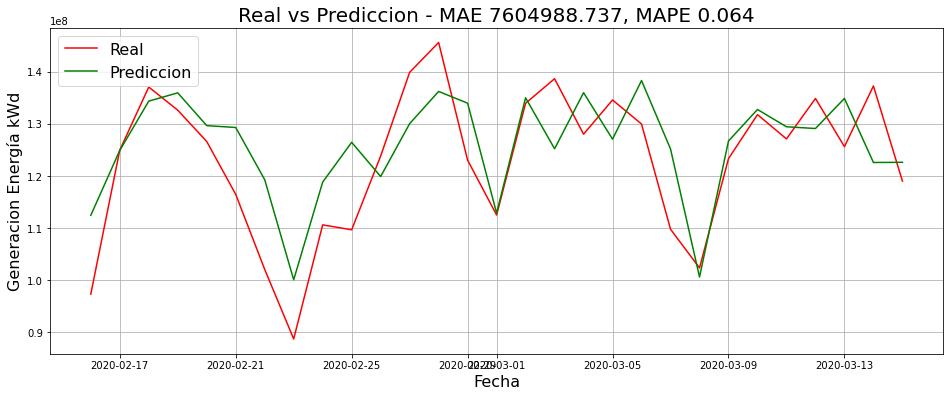

In [1003]:
predicciones['Date'] = generacion_renovable_test_covid.index[1:]
predicciones.set_index('Date', inplace=True)

mae = np.round(mean_absolute_error(generacion_renovable_test_covid['total_generacion'].values[1:], predicciones.values), 3)   
mape = np.round(mean_absolute_percentage_error(generacion_renovable_test_covid['total_generacion'].values[1:], predicciones.values), 3)


#plot reality vs prediction for the last week of the dataset
fig = plt.figure(figsize=(16,6))
plt.title(f'Real vs Prediccion - MAE {mae}, MAPE {mape}', fontsize=20)
plt.plot(generacion_renovable_test_covid.iloc[1:]['total_generacion'], color='red')
plt.plot(predicciones, color='green')
plt.xlabel('Fecha', fontsize=16)
plt.ylabel('Generacion Energía kWd', fontsize=16)
plt.legend(labels=['Real', 'Prediccion'], fontsize=16)
plt.grid()
plt.show()

Era de esperar que la predicción en la variable de generación fuera menos satisfactoria, debido a que esta variable es más volatil que la demanda, y depende de aspectos ambientales de mayor impacto (para la generación de energía, tales como: caudales, vientos, nubisidad).

Sin embargo, haremos uso de esta predicción, debido a que da resultados aproximados provenientes de un comportamiento normal, sin considerar efectos covid.

In [1004]:
fin_covid = '2020-07-31'
generacion_en_covid = generacion_renovable.loc[inicio_covid : fin_covid, :]

step = pd.date_range(inicio_covid, fin_covid, freq='D').to_series().shape[0] 

predictions = forecaster_covid_generacion.predict(steps=step, exog=generacion_en_covid[variables_exogenas])

In [1005]:
predictions = predictions.to_frame()
predictions['Date'] = generacion_en_covid.index
predictions.set_index('Date', inplace=True)

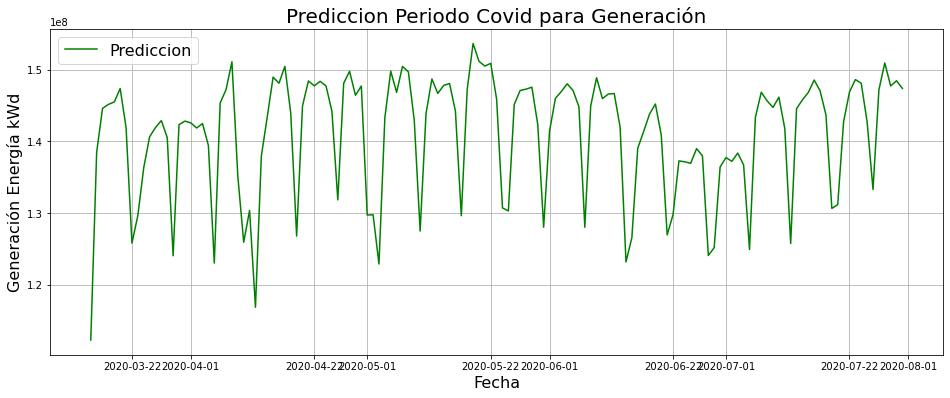

In [1006]:
#plot reality vs prediction for the last week of the dataset
fig = plt.figure(figsize=(16,6))
plt.title(f'Prediccion Periodo Covid para Generación', fontsize=20)
plt.plot(predictions, color='green')
plt.xlabel('Fecha', fontsize=16)
plt.ylabel('Generación Energía kWd', fontsize=16)
plt.legend(labels=['Prediccion'], fontsize=16)
plt.grid()
plt.show()

In [1007]:
generacion_corregida = generacion_renovable.copy()
periodo_covid = pd.date_range(inicio_covid, fin_covid, freq='D')
generacion_corregida.loc[periodo_covid, 'total_generacion'] = predictions['pred']

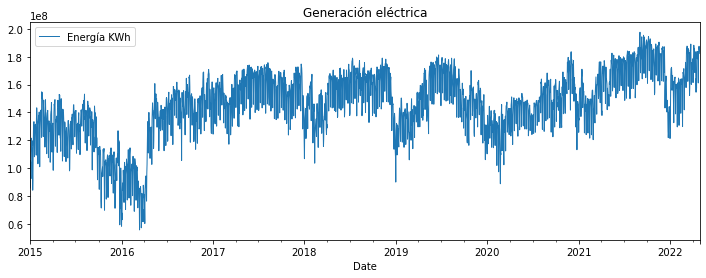

In [1008]:
# Gráfico Demanda CORREGIDA
# ==============================================================================

fig, ax = plt.subplots(figsize=(12, 4))
generacion_corregida['total_generacion'].plot(ax=ax, label='Energía KWh', linewidth=1)

ax.set_title('Generación eléctrica')
ax.legend();

#### Modelos con XGBoost

Ahora, una vez corregida las series procedemos a separar definitivamente en train, test y validación para ambas series para entrenar los modelos definitivos.

En el ejercicio anterior, utilizamos el conjunto de validación para validar los resultados desde el modelo, más no la predicción. Es decir, intercambiamos los nombres de los conjuntos, pero para esta evaluación se hará como generalmente se hace en la literatura, usando test para el modelo y validación para la predicción final.

In [1009]:
# Separación datos train-val-test
# ==============================================================================
fin_train= '2021-01-01'
fin_test = '2022-01-01'
demanda_corregida_train = demanda_corregida.loc[: fin_train, :]
demanda_corregida_test   = demanda_corregida.loc[fin_train:fin_test, :]
demanda_corregida_val  = demanda_corregida.loc[fin_test:, :]

generacion_corregida_train = generacion_corregida.loc[: fin_train, :]
generacion_corregida_test   = generacion_corregida.loc[fin_train:fin_test, :]
generacion_corregida_val  = generacion_corregida.loc[fin_test:, :]

#### Ajuste de hiperparametros

Anteriormente ajustamos 3 hiperparametros para entrenar los modelos presentados, sin considerar aspectos relevantes de este tipo de modelo tales como el weak learner, los hiperparametros de aprendizaje o los propios hiperparametros del weak learner utilizado. Por tanto, se considera para el siguiente entrenamiento algunos de los hiperparametros más importantes además de los anteriormente utilizados.

Los hiperparametros a usar serán entonces:

- booster: hace referencia al weak learner, el cual puede ser un árbol o una regresión lineal.
- learning_rate: tasa de cambio en los párametros de aprendizaje, entre menor sea esta más se evita el sobre ajuste.
- max_depth: Profundidad máxima del árbol. Entre más profundo mayor capacidad de predicción, pero si se es muy grande existe mayor sobre ajuste.
- n_estimators: Número de weak learners a utilizar

Estos 4 son los hiperparametros de mayor importancia. Sin embargo, utilizaremos otros que también aportan al modelamiento
- gamma: Se refire a cuanto aporta el resultado una partición adicional del árbol, a mayor valor de gamma menor sobre ajuste.
- lambda: tasa de regularización L2. Sirve para evitar el sobre ajuste.

Para el booster usaremos árboles.

In [1010]:
# Crear forecaster
# ==============================================================================
forecaster_demanda = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 31
             )


# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3,5,7,9],
    'learning_rate': [0.01, 0.05, 1],
    'gamma': [0.2, 0.6],
    'lambda': [0.4, 0.8],
}

# Lags utilizados como predictores
lags_grid = [8, [1, 2, 6, 7, 8, 14, 15, 28, 365], [1,2,7,14,28,365], [1,365], [1,7,365], [1,7,14,365]]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster_demanda,
                        y                  = demanda_corregida.loc[:fin_test, 'Demanda'],
                        exog               = demanda_corregida.loc[:fin_test, variables_exogenas],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 30,
                        refit              = False,
                        metric             = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(demanda_corregida_train)),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 1152


loop param_grid:  44%|███████████████▍                   | 85/192 [01:33<01:47,  1.00s/it]


loop param_grid:  90%|██████████████████████████████▍   | 172/192 [03:11<00:26,  1.34s/it]


loop param_grid:  34%|███████████▊                       | 65/192 [01:14<02:16,  1.08s/it]


loop param_grid:  79%|██████████████████████████▉       | 152/192 [02:51<00:42,  1.07s/it]


loop param_grid:  23%|████████▏                          | 45/192 [00:46<02:32,  1.04s/it]


loop param_grid:  69%|███████████████████████▍          | 132/192 [02:18<01:12,  1.20s/it]


loop param_grid:  13%|████▌                              | 25/192 [00:28<02:56,  1.06s/it]


loop param_grid:  58%|███████████████████▊              | 112/192 [02:03<01:33,  1.17s/it]


loop param_grid:   3%|▉                                   | 5/192 [00:04<03:05,  1.01it/s]


loop param_grid:  48%|████████████████▊                  | 92/192 [01:46<02:02,  1.22s/it]


loop param_grid:  93%|███████████████████████████████▋  | 179/192 [03:19<00:14,  1.10s/it]


loop param_grid:  38%|█████████████▏                     | 72/192 [01:15<02:11,  1.10s/it]


loop param_grid:  83%|████████████████████████████▏     | 159/192 [02:53<00:37,  1.14s/it]


loop lags_grid: 100%|██████████████████████████████████████| 6/6 [21:21<00:00, 213.62s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   7  14  28 365] 
  Parameters: {'gamma': 0.2, 'lambda': 0.4, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400}
  Backtesting metric: 0.025524429000943594



In [1013]:
resultados_grid.head(10)

,lags,params,metric,gamma,lambda,learning_rate,max_depth,n_estimators
403,"[1, 2, 7, 14, 28, 365]","{'gamma': 0.2, 'lambda': 0.4, 'learning_rate':...",0.025524,0.2,0.4,0.05,3.0,400.0
499,"[1, 2, 7, 14, 28, 365]","{'gamma': 0.6, 'lambda': 0.4, 'learning_rate':...",0.025524,0.6,0.4,0.05,3.0,400.0
498,"[1, 2, 7, 14, 28, 365]","{'gamma': 0.6, 'lambda': 0.4, 'learning_rate':...",0.026140,0.6,0.4,0.05,3.0,300.0
402,"[1, 2, 7, 14, 28, 365]","{'gamma': 0.2, 'lambda': 0.4, 'learning_rate':...",0.026140,0.2,0.4,0.05,3.0,300.0
1092,"[1, 7, 14, 365]","{'gamma': 0.6, 'lambda': 0.4, 'learning_rate':...",0.026484,0.6,0.4,1.00,5.0,100.0
996,"[1, 7, 14, 365]","{'gamma': 0.2, 'lambda': 0.4, 'learning_rate':...",0.026484,0.2,0.4,1.00,5.0,100.0
407,"[1, 2, 7, 14, 28, 365]","{'gamma': 0.2, 'lambda': 0.4, 'learning_rate':...",0.026611,0.2,0.4,0.05,5.0,400.0
503,"[1, 2, 7, 14, 28, 365]","{'gamma': 0.6, 'lambda': 0.4, 'learning_rate':...",0.026611,0.6,0.4,0.05,5.0,400.0
211,"[1, 2, 6, 7, 8, 14, 15, 28, 365]","{'gamma': 0.2, 'lambda': 0.4, 'learning_rate':...",0.026647,0.2,0.4,0.05,3.0,400.0
307,"[1, 2, 6, 7, 8, 14, 15, 28, 365]","{'gamma': 0.6, 'lambda': 0.4, 'learning_rate':...",0.026647,0.6,0.4,0.05,3.0,400.0


In [1014]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster         = forecaster_demanda,
    y                  = demanda_corregida['Demanda'],
    exog               = demanda_corregida[variables_exogenas],
    initial_train_size = len(demanda_corregida.loc[:fin_test]),
    steps              = 30,
    refit              = False,
    metric             = 'mean_absolute_percentage_error',
    verbose            = False
)

print(f"Error de backtest: {metric}")

Error de backtest: 0.016668755839676495


In [1015]:
predicciones['Date'] = demanda_corregida_val.index[1:]
predicciones.set_index('Date', inplace=True)

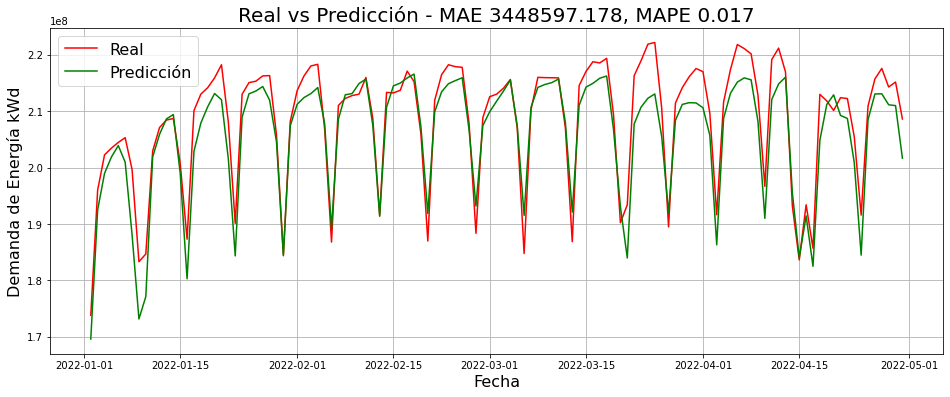

In [1016]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

mae = np.round(mean_absolute_error(demanda_corregida_val['Demanda'].values[1:], predicciones.values), 3)   
mape = np.round(mean_absolute_percentage_error(demanda_corregida_val['Demanda'].values[1:], predicciones.values), 3)


#plot reality vs prediction for the last week of the dataset
fig = plt.figure(figsize=(16,6))
plt.title(f'Real vs Predicción - MAE {mae}, MAPE {mape}', fontsize=20)
plt.plot(demanda_corregida_val.iloc[1:]['Demanda'], color='red')
plt.plot(predicciones, color='green')
plt.xlabel('Fecha', fontsize=16)
plt.ylabel('Demanda de Energía kWd', fontsize=16)
plt.legend(labels=['Real', 'Predicción'], fontsize=16)
plt.grid()
plt.show()

In [1017]:
# Crear forecaster
# ==============================================================================
forecaster_generacion = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 31
             )


# Grid search de hiperparámetros
# ==============================================================================
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3,5,7,9],
    'learning_rate': [0.01, 0.05, 1],
    'gamma': [0.2, 0.6],
    'lambda': [0.4, 0.8],
}

# Lags utilizados como predictores
lags_grid = [8, [1, 2, 6, 7, 8, 14, 15, 28, 365], [1,2,7,14,28,365], [1,365], [1,7,365], [1,7,14,365]]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster_generacion,
                        y                  = generacion_corregida.loc[:fin_test, 'total_generacion'],
                        exog               = generacion_corregida.loc[:fin_test, variables_exogenas],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 30,
                        refit              = False,
                        metric             = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(generacion_corregida_train)),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 1152


loop param_grid:  44%|███████████████▍                   | 85/192 [01:40<01:48,  1.02s/it]


loop param_grid:  90%|██████████████████████████████▍   | 172/192 [03:16<00:25,  1.28s/it]


loop param_grid:  34%|███████████▊                       | 65/192 [01:12<02:30,  1.19s/it]


loop param_grid:  79%|██████████████████████████▉       | 152/192 [02:46<00:41,  1.03s/it]


loop param_grid:  23%|████████▏                          | 45/192 [00:46<02:34,  1.05s/it]


loop param_grid:  69%|███████████████████████▍          | 132/192 [02:16<01:00,  1.01s/it]


loop param_grid:  13%|████▌                              | 25/192 [00:24<02:47,  1.00s/it]


loop param_grid:  58%|███████████████████▊              | 112/192 [01:51<01:33,  1.17s/it]


loop param_grid:   3%|▉                                   | 5/192 [00:04<02:55,  1.07it/s]


loop param_grid:  48%|████████████████▊                  | 92/192 [01:36<01:46,  1.07s/it]


loop param_grid:  93%|███████████████████████████████▋  | 179/192 [03:08<00:13,  1.01s/it]


loop param_grid:  38%|█████████████▏                     | 72/192 [01:15<02:11,  1.10s/it]


loop param_grid:  83%|████████████████████████████▏     | 159/192 [02:50<00:37,  1.13s/it]


loop lags_grid: 100%|██████████████████████████████████████| 6/6 [20:32<00:00, 205.48s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7 8] 
  Parameters: {'gamma': 0.2, 'lambda': 0.8, 'learning_rate': 1, 'max_depth': 3, 'n_estimators': 400}
  Backtesting metric: 0.047869812650261696



In [1021]:
resultados_grid.head(10)

,lags,params,metric,gamma,lambda,learning_rate,max_depth,n_estimators
83,"[1, 2, 3, 4, 5, 6, 7, 8]","{'gamma': 0.2, 'lambda': 0.8, 'learning_rate':...",0.047870,0.2,0.8,1.0,3.0,400.0
179,"[1, 2, 3, 4, 5, 6, 7, 8]","{'gamma': 0.6, 'lambda': 0.8, 'learning_rate':...",0.047870,0.6,0.8,1.0,3.0,400.0
178,"[1, 2, 3, 4, 5, 6, 7, 8]","{'gamma': 0.6, 'lambda': 0.8, 'learning_rate':...",0.049653,0.6,0.8,1.0,3.0,300.0
82,"[1, 2, 3, 4, 5, 6, 7, 8]","{'gamma': 0.2, 'lambda': 0.8, 'learning_rate':...",0.049653,0.2,0.8,1.0,3.0,300.0
176,"[1, 2, 3, 4, 5, 6, 7, 8]","{'gamma': 0.6, 'lambda': 0.8, 'learning_rate':...",0.050588,0.6,0.8,1.0,3.0,100.0
80,"[1, 2, 3, 4, 5, 6, 7, 8]","{'gamma': 0.2, 'lambda': 0.8, 'learning_rate':...",0.050588,0.2,0.8,1.0,3.0,100.0
177,"[1, 2, 3, 4, 5, 6, 7, 8]","{'gamma': 0.6, 'lambda': 0.8, 'learning_rate':...",0.053621,0.6,0.8,1.0,3.0,200.0
81,"[1, 2, 3, 4, 5, 6, 7, 8]","{'gamma': 0.2, 'lambda': 0.8, 'learning_rate':...",0.053621,0.2,0.8,1.0,3.0,200.0
993,"[1, 7, 14, 365]","{'gamma': 0.2, 'lambda': 0.4, 'learning_rate':...",0.055221,0.2,0.4,1.0,3.0,200.0
1089,"[1, 7, 14, 365]","{'gamma': 0.6, 'lambda': 0.4, 'learning_rate':...",0.055221,0.6,0.4,1.0,3.0,200.0


In [1023]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster         = forecaster_generacion,
    y                  = generacion_corregida['total_generacion'],
    exog               = generacion_corregida[variables_exogenas],
    initial_train_size = len(generacion_corregida.loc[:fin_test]),
    steps              = 30,
    refit              = False,
    metric             = 'mean_absolute_percentage_error',
    verbose            = False
)

print(f"Error de backtest: {metric}")

Error de backtest: 0.2472106726964323


In [1024]:
predicciones['Date'] = generacion_corregida_val.index[1:]
predicciones.set_index('Date', inplace=True)

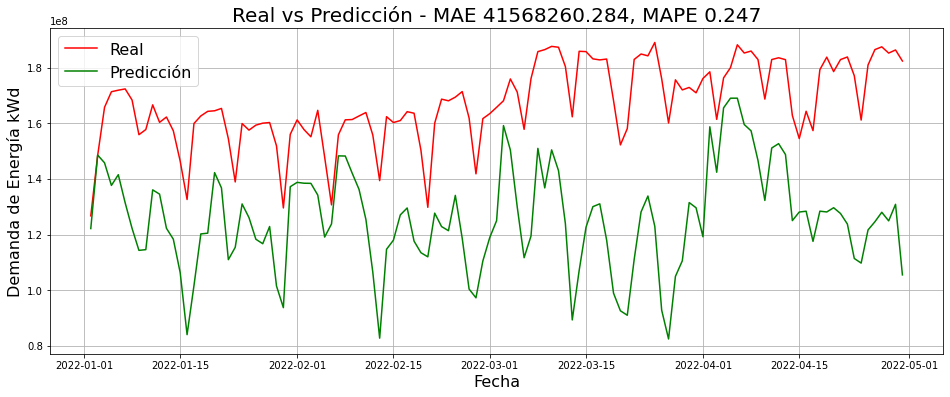

In [1025]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

mae = np.round(mean_absolute_error(generacion_corregida_val['total_generacion'].values[1:], predicciones.values), 3)   
mape = np.round(mean_absolute_percentage_error(generacion_corregida_val['total_generacion'].values[1:], predicciones.values), 3)


#plot reality vs prediction for the last week of the dataset
fig = plt.figure(figsize=(16,6))
plt.title(f'Real vs Predicción - MAE {mae}, MAPE {mape}', fontsize=20)
plt.plot(generacion_corregida_val.iloc[1:]['total_generacion'], color='red')
plt.plot(predicciones, color='green')
plt.xlabel('Fecha', fontsize=16)
plt.ylabel('Demanda de Energía kWd', fontsize=16)
plt.legend(labels=['Real', 'Predicción'], fontsize=16)
plt.grid()
plt.show()